# Food Framing Analysis Script

## Adapted from Tomas Folke 2016 by Pradyumna Sepulveda, Amy Benson and Benedetto de Martino

# Contents

# Data Preparation
## [Load Data](#LoadData)
## [Eye Blink Check](#CheckBlinks)
## [Calculate GSF](#GSF)
## [Calculate DDT](#DDT)
## [Summary Measures](#summary)
## [Compute z and familiarity variables](#zfam)
## [Median Split](#split) 
## [Participant Exclusion](#PartEx)
# Data Analysis
## [Correlation Graphs](#corr)
## [Logistic Plots](#log)
## [Regression Analysis](#reg)

# Import Packages

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import rpy2
%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [125]:
%%R
# Use in case the libraries are not available in the system
#install.packages("lme4")
#install.packages("car")
#install.packages("ggplot2")
#install.packages("broom")
#install.packages("arm")
#install.packages("ggplot2")
#install.packages("optimx")
install.packages("multcomp")






In [126]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)

# Defining Functions

## Taken from Tomas Folke

### Plot distributions

In [5]:
def participant_densities(data, var, xlim=(0,100), rug=True):
    # a counter that tells us where a given participant's data should be plotted
    order = 1

    # a list of all the participants in the dataset
    participants = data.loc[:, 'Part'].unique()

    # defining the figure size
    sns.set_style('white')
    fig = figure(figsize=(15,70))

    for x in participants:
        # defining the sub figures
            sub={}
            sub['%s' % x] = plt.subplot(len(participants)/2, 3, order)
            sns.kdeplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x], shade=True)
            #if rug==True:
            #    sns.rugplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x])
            sub['%s' % x].set_title('participant %s' % x)
            #sub['%s' % x].set_xlim(xlim)
            order += 1

### Split variable into participantwise quantiles

In [6]:
def parsplit(DF, input, quantiles):
    qvalues = pd.qcut(DF[input], quantiles, labels = range(1, quantiles+1))
    return qvalues

### Full simple logistic graph

In [7]:
def logisticplot_all (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()


    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()

    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5)


    #Plotting the binned data
    data['DVBin2'] = data.groupby(parvar).apply(parsplit, input=xaxis, quantiles=4).values
    
    # determine the x coordinates
    x_cords= data.groupby('DVBin2')[xaxis].mean()
    
    # determine low y coordinates
    y_cords_low = data.loc[(data[moderator]==0), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine low y standard errors
    test = pd.DataFrame(data.loc[(data[moderator]==0), :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_low_error = test.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    
    # determine high y coordinates
    y_cords_high = data.loc[(data[moderator]==1), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine high y standard errors
    test2 = pd.DataFrame(data.loc[data[moderator]==1, :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_high_error = test2.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    # plot the low points
    plt.scatter(x_cords, y_cords_low, c=modlowcol, marker='D', s=60, zorder=1)
    # plot low error bars
    plt.errorbar(x_cords, y_cords_low, yerr=y_low_error, fmt='o', zorder=3, c=modlowcol)
    
    # plot the high points
    plt.scatter(x_cords, y_cords_high, c=modhighcol, marker='o', s=60, zorder=2)
    # plot high error bars
    plt.errorbar(x_cords, y_cords_high, yerr=y_high_error, fmt='o', zorder=4, c=modhighcol)
    
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=2, prop={'size':20})
    sns.despine()

### Regression Coefficients Plot

In [241]:
def Coefpresplot(regtable, intercept=False, title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)

    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not    
    if intercept == True:
        XLim = (0.75, len(regtable.columns) + 0.25)
        YLim = (round_to_5(regtable.loc['CImin', :].min()-0.1), round_to_5(regtable.loc['CImax', :].max()+0.2))
    else:
        XLim = (0.75, len(regtable.columns) - 0.75)
        YLim = (round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()-0.2), round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()+0.2))
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    if intercept == True:
        Coefficients = regtable.columns
    else:
        Coefficients = regtable.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = ['#000000'] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.plot(position, regtable.loc['coefficient', Coefficient], marker='o', ms=8, color=colourlist[position-1],)
        ax.errorbar(position, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color=colourlist[position-1])

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Fixed Effects Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [337]:
def Coefpresplot2(regtable,regtable2, intercept=False, title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)

    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not    
    
       
    
    if intercept == True:
        
        XLim = (0.75, len(regtable.columns) + 0.25)
        
        #Determine the Ymax and Ymin for both regresions results
        if round_to_5(regtable.loc['CImin', :].min()) < round_to_5(regtable2.loc['CImin', :].min()):
            Ymin = round_to_5(regtable.loc['CImin', :].min()-0.5)
        else :
            Ymin = round_to_5(regtable2.loc['CImin',:].min()-0.5)
        if round_to_5(regtable.loc['CImax', :].max()) > round_to_5(regtable2.loc['CImax', :].max()):
            Ymax = round_to_5(regtable.loc['CImax', :].max()+0.5)
        else :
            Ymax = round_to_5(regtable2.loc['CImax', :].max()+0.5)      

        YLim = (Ymin, Ymax)    
    else:
        XLim = (0.75, len(regtable.columns) - 0.75)
        
        #Determine the Ymax and Ymin for both regresions results
        if round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()) < round_to_5(regtable2.loc['CImin', regtable.columns[1]:].min()):
            Ymin = round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()-0.5)
        else :
            Ymin = round_to_5(regtable2.loc['CImin',regtable.columns[1]:].min()-0.5)
        if round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()) > round_to_5(regtable2.loc['CImax', regtable.columns[1]:].max()):
            Ymax = round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()+0.5)
        else :
            Ymax = round_to_5(regtable2.loc['CImax', regtable.columns[1]:].max()+0.5)      
        
        YLim = (Ymin, Ymax)
    
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # both regtable should have the same regressors (and in the same order)

    if intercept == True:
        Coefficients = regtable.columns
 #       Coefficients2 = regtable2.columns
    else:
        Coefficients = regtable.columns[1:]
#        Coefficients2 = regtable2.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = ['#000000'] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.plot(position-0.1, regtable.loc['coefficient', Coefficient], marker='o', ms=8, color='blue',)
        ax.plot(position+0.1, regtable2.loc['coefficient', Coefficient], marker='X', ms=8, color='red',)


        ax.errorbar(position-0.1, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color='blue')
        ax.errorbar(position+0.1, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='red')
 
    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))

    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Fixed Effects Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [269]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

# Data Preparation
_____________________________________________________________________________________________________________________

<a id='LoadData'></a>
# Loading Pilot Data

### Load eyetracker data reports generated by EyeLink DataViewer.
#### Loading Interest Area (IA) and Saccade (Sacc) reports

In [8]:
pX_IA ="/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Reports/IA_FullReport_v3.txt"
pX_Sacc ="/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Reports/SACC_FullReport_v3.txt"

pX_IAframe = [pd.read_csv(pX_IA, sep="\t")]
pX_Saccframe = [pd.read_csv(pX_Sacc, sep="\t")]
pX_IAdata = pd.concat(pX_IAframe)
pX_SACCdata = pd.concat(pX_Saccframe)

#### Dataframe with interest Area information

In [9]:
pX_IAdata

DATA_FILE  IA_ID  trial  Triplet_Identity  trial_type  \
0        p1.edf      1      1                14  Experiment   
1        p1.edf      2      1                14  Experiment   
2        p1.edf      3      1                14  Experiment   
3        p1.edf      1      2                44  Experiment   
4        p1.edf      2      2                44  Experiment   
5        p1.edf      3      2                44  Experiment   
6        p1.edf      1      3                51  Experiment   
7        p1.edf      2      3                51  Experiment   
8        p1.edf      3      3                51  Experiment   
9        p1.edf      1      4                12  Experiment   
10       p1.edf      2      4                12  Experiment   
11       p1.edf      3      4                12  Experiment   
12       p1.edf      1      5                 4  Experiment   
13       p1.edf      2      5                 4  Experiment   
14       p1.edf      3      5                 4  Experiment   
15       p1.edf      1      6                39  Experiment   
16       p1.edf      2      6                39  Experiment   
17       p1.edf      3      6                39  Experiment   
18       p1.edf      1      7                59  Experiment   
19       p1.edf      2      7                59  Experiment   
20       p1.edf      3      7                59  Experiment   
21       p1.edf      1      8                16  Experiment   
22       p1.edf      2      8                16  Experiment   
23       p1.edf      3      8                16  Experiment   
24       p1.edf      1      9                 1  Experiment   
25       p1.edf      2      9                 1  Experiment   
26       p1.edf      3      9                 1  Experiment   
27       p1.edf      1     10                48  Experiment   
28       p1.edf      2     10                48  Experiment   
29       p1.edf      3     10                48  Experiment   
...         ...    ...    ...               ...         ...   
28770   p43.edf      1    231                17  Experiment   
28771   p43.edf      2    231                17  Experiment   
28772   p43.edf      3    231                17  Experiment   
28773   p43.edf      1    232                22  Experiment   
28774   p43.edf      2    232                22  Experiment   
28775   p43.edf      3    232                22  Experiment   
28776   p43.edf      1    233                56  Experiment   
28777   p43.edf      2    233                56  Experiment   
28778   p43.edf      3    233                56  Experiment   
28779   p43.edf      1    234                52  Experiment   
28780   p43.edf      2    234                52  Experiment   
28781   p43.edf      3    234                52  Experiment   
28782   p43.edf      1    235                39  Experiment   
28783   p43.edf      2    235                39  Experiment   
28784   p43.edf      3    235                39  Experiment   
28785   p43.edf      1    236                51  Experiment   
28786   p43.edf      2    236                51  Experiment   
28787   p43.edf      3    236                51  Experiment   
28788   p43.edf      1    237                55  Experiment   
28789   p43.edf      2    237                55  Experiment   
28790   p43.edf      3    237                55  Experiment   
28791   p43.edf      1    238                18  Experiment   
28792   p43.edf      2    238                18  Experiment   
28793   p43.edf      3    238                18  Experiment   
28794   p43.edf      1    239                42  Experiment   
28795   p43.edf      2    239                42  Experiment   
28796   p43.edf      3    239                42  Experiment   
28797   p43.edf      1    240                54  Experiment   
28798   p43.edf      2    240                54  Experiment   
28799   p43.edf      3    240                54  Experiment   

                               LL_Item  LL_Value  \
0               116_boots_caramels.png      0.9

#### Dataframe with saccade information

In [10]:
pX_SACCdata

DATA_FILE  trial  Triplet_Identity CURRENT_SAC_START_INTEREST_AREA_ID  \
0         p1.edf    145               145                                  .   
1         p1.edf    145               145                                  .   
2         p1.edf    145               145                                  .   
3         p1.edf    145               145                                  .   
4         p1.edf    145               145                                  .   
5         p1.edf    145               145                                  .   
6         p1.edf    145               145                                  .   
7         p1.edf    145               145                                  .   
8         p1.edf    145               145                                  .   
9         p1.edf    145               145                                  .   
10        p1.edf    145               145                                  .   
11        p1.edf    145               145                                  .   
12        p1.edf    145               145                                  .   
13        p1.edf    145               145                                  .   
14        p1.edf    145               145                                  .   
15        p1.edf    145               145                                  .   
16        p1.edf    145               145                                  .   
17        p1.edf    145               145                                  .   
18        p1.edf    145               145                                  .   
19        p1.edf    145               145                                  .   
20        p1.edf    145               145                                  .   
21        p1.edf    145               145                                  .   
22        p1.edf    145               145                                  .   
23        p1.edf    145               145                                  .   
24        p1.edf    145               145                                  .   
25        p1.edf    145               145                                  .   
26        p1.edf    145               145                                  .   
27        p1.edf    145               145                                  .   
28        p1.edf    145               145                                  .   
29        p1.edf    145               145                                  .   
...          ...    ...               ...                                ...   
106234   p43.edf    238                18                                  2   
106235   p43.edf    238                18                                  2   
106236   p43.edf    238                18                                  2   
106237   p43.edf    238                18                                  .   
106238   p43.edf    238                18                                  1   
106239   p43.edf    239                42                                  2   
106240   p43.edf    239                42                                  2   
106241   p43.edf    239                42                                  .   
106242   p43.edf    239                42                                  1   
106243   p43.edf    239                42                                  1   
106244   p43.edf    239                42                                  1   
106245   p43.edf    239                42                                  1   
106246   p43.edf    239                42                                  2   
106247   p43.edf    239                42                                  2   
106248   p43.edf    239                42                                  2   
106249   p43.edf    239                42                                  2   
106250   p43.edf    239                42                                  2   
106251   p43.edf    239                42                                  2   
106252 

## Number of participants and trials 

In [11]:
participant = pX_IAdata['DATA_FILE'].unique()
participant_names = pX_IAdata['DATA_FILE'].unique()

#Extract just names of participant (for folder name in future steps)
yy=0
for xx in participant_names:
    participant_names[yy]=xx.rstrip(".edf")
    yy+=1
print (participant_names)

trial_n = pX_IAdata['trial'].unique()

print("Number of participants:", len(participant))
print ("Number of trials:", len( trial_n))

['p1' 'p5' 'p6' 'p7' 'p8' 'p9' 'p10' 'p11' 'p12' 'p13' 'p14' 'p15' 'p16'
 'p17' 'p18' 'p19' 'p20' 'p21' 'p22' 'p23' 'p24' 'p25' 'p26' 'p27' 'p28'
 'p29' 'p30' 'p31' 'p32' 'p33' 'p34' 'p35' 'p36' 'p37' 'p38' 'p39' 'p40'
 'p41' 'p42' 'p43']
Number of participants: 40
Number of trials: 240


<a id='CheckBlinks'></a>
# Check Blinks across participants

#### Loading dataframe containing trial information for all the participants

In [12]:
pX_TrialRep ="/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Reports/TrialReport_Blinks_v1.txt"
TrialRepFrame = [pd.read_csv(pX_TrialRep, sep="\t")]
TrialDataFrame = pd.concat(TrialRepFrame)
TrialDataFrame

DATA_FILE    IP_LABEL  trial  Triplet_Identity  Block_Cond  BLINK_COUNT  \
0       p1.edf  ChoiceOnly    145               145         1.0            6   
1       p1.edf  ChoiceOnly    146               146         2.0            0   
2       p1.edf  ChoiceOnly    147               147         2.0            0   
3       p1.edf  ChoiceOnly    148               148         1.0            0   
4       p1.edf  ChoiceOnly      1                14         2.0            1   
5       p1.edf  ChoiceOnly      2                44         2.0            0   
6       p1.edf  ChoiceOnly      3                51         2.0            0   
7       p1.edf  ChoiceOnly      4                12         2.0            4   
8       p1.edf  ChoiceOnly      5                 4         2.0            0   
9       p1.edf  ChoiceOnly      6                39         2.0            0   
10      p1.edf  ChoiceOnly      7                59         2.0            0   
11      p1.edf  ChoiceOnly      8                16         2.0            1   
12      p1.edf  ChoiceOnly      9                 1         2.0            0   
13      p1.edf  ChoiceOnly     10                48         2.0            1   
14      p1.edf  ChoiceOnly     11                37         2.0            1   
15      p1.edf  ChoiceOnly     12                 6         2.0            1   
16      p1.edf  ChoiceOnly     13                35         2.0            1   
17      p1.edf  ChoiceOnly     14                45         2.0            1   
18      p1.edf  ChoiceOnly     15                58         2.0            1   
19      p1.edf  ChoiceOnly     16                41         2.0            0   
20      p1.edf  ChoiceOnly     17                42         2.0            0   
21      p1.edf  ChoiceOnly     18                52         2.0            0   
22      p1.edf  ChoiceOnly     19                49         2.0            0   
23      p1.edf  ChoiceOnly     20                33         2.0            0   
24      p1.edf  ChoiceOnly     21                 7         2.0            0   
25      p1.edf  ChoiceOnly     22                38         2.0            0   
26      p1.edf  ChoiceOnly     23                47         2.0            0   
27      p1.edf  ChoiceOnly     24                34         2.0            1   
28      p1.edf  ChoiceOnly     25                15         2.0            0   
29      p1.edf  ChoiceOnly     26                 5         2.0            0   
...        ...         ...    ...               ...         ...          ...   
9730   p43.edf  ChoiceOnly    211                45         1.0            0   
9731   p43.edf  ChoiceOnly    212                46         1.0            0   
9732   p43.edf  ChoiceOnly    213                43         1.0            0   
9733   p43.edf  ChoiceOnly    214                16         1.0            1   
9734   p43.edf  ChoiceOnly    215                30         1.0            0   
9735   p43.edf  ChoiceOnly    216                37         1.0            0   
9736   p43.edf  ChoiceOnly    217                38         1.0            1   
9737   p43.edf  ChoiceOnly    218                49         1.0            1   
9738   p43.edf  ChoiceOnly    219                48         1.0            1   
9739   p43.edf  ChoiceOnly    220                31         1.0            0   
9740   p43.edf  ChoiceOnly    221                26         1.0            0   
9741   p43.edf  ChoiceOnly    222                40         1.0            0   
9742   p43.edf  ChoiceOnly    223                24         1.0            1   
9743   p43.edf  ChoiceOnly    224                53         1.0            2   
9744   p43.edf  ChoiceOnly    225                41         1.0            1   
9745   p43.edf  ChoiceOnly    226                20         1.0            0   
9746   p43.edf  ChoiceOnly    227                29         1.0            0   
9747   p43.edf  ChoiceOnly    228                50         1.0            0   
9748 

In [13]:
BlinkMatrix = []
partBlink = TrialDataFrame['DATA_FILE'].unique()
partBlink

array(['p1.edf', 'p5.edf', 'p6.edf', 'p7.edf', 'p8.edf', 'p9.edf',
       'p10.edf', 'p11.edf', 'p12.edf', 'p13.edf', 'p14.edf', 'p15.edf',
       'p16.edf', 'p17.edf', 'p18.edf', 'p19.edf', 'p20.edf', 'p21.edf',
       'p22.edf', 'p23.edf', 'p24.edf', 'p25.edf', 'p26.edf', 'p27.edf',
       'p28.edf', 'p29.edf', 'p30.edf', 'p31.edf', 'p32.edf', 'p33.edf',
       'p34.edf', 'p35.edf', 'p36.edf', 'p37.edf', 'p38.edf', 'p39.edf',
       'p40.edf', 'p41.edf', 'p42.edf', 'p43.edf'], dtype=object)

In [14]:
# Extracting information for each participant

for k in range(0,len(partBlink)):
 
    pX_Blinks = TrialDataFrame.loc[(TrialDataFrame['DATA_FILE']==partBlink[k]) & (TrialDataFrame['trial_type']== 'Experiment')]
    
    
    
    Blink_Count_trial =  pX_Blinks['BLINK_COUNT']
    Blink_Average_trial =  pd.to_numeric(pX_Blinks['AVERAGE_BLINK_DURATION'], errors='coerce')
    Duration_trial =  pd.to_numeric(pX_Blinks['DURATION'], errors='coerce')


    Blink_Count_part = Blink_Count_trial.mean()
    Blink_CountSD_part = Blink_Count_trial.std()
    Blink_Average_part = Blink_Average_trial.mean(skipna = True)
    Blink_AverageSD_part = Blink_Average_trial.std(skipna = True)
    Duration_part = Duration_trial.mean(skipna = True)

    BlinkMatrix.append([partBlink[k] , Blink_Count_part, Blink_CountSD_part, Blink_Average_part, Blink_AverageSD_part, Duration_part]) 
    

BlinkMatrix=pd.DataFrame(BlinkMatrix,columns=['Participant', 'BlinkCountAverage', 'BlinkCountStd', 'BlinkTimeAverage', 'BlinkTimeAverageStd','TrialDurationAverage'])



##### BlinkCountAverage : mean blink number during all the trials for each participant
##### BlinkTimeAverage : mean duration (ms) of a blink event for each participant
##### TrialDurationAverage : mean duration (ms) of the trial for each participant

In [15]:
BlinkMatrix

Participant  BlinkCountAverage  BlinkCountStd  BlinkTimeAverage  \
0       p1.edf           0.370833       0.672209         92.042254   
1       p5.edf           1.687500       1.163537        189.220090   
2       p6.edf           1.070833       0.881696        115.250879   
3       p7.edf           1.195833       1.038578        135.605978   
4       p8.edf           1.054167       1.128364        106.463613   
5       p9.edf           3.137500       1.214388        132.536250   
6      p10.edf           0.445833       0.624787        133.271739   
7      p11.edf           0.154167       0.538461        169.118929   
8      p12.edf           0.329167       0.610219        208.746032   
9      p13.edf           2.287500       1.041327        157.710462   
10     p14.edf           1.579167       1.019672        167.421549   
11     p15.edf           0.716667       0.559188        221.297937   
12     p16.edf           0.583333       0.858951        193.287234   
13     p17.edf           0.408333       0.606738        144.575581   
14     p18.edf           0.520833       0.980769        310.895244   
15     p19.edf           0.654167       0.829114         92.862773   
16     p20.edf           0.904167       1.068366        168.825733   
17     p21.edf           0.262500       0.527338        122.266140   
18     p22.edf           0.758333       0.640291        391.799557   
19     p23.edf           0.033333       0.179881        234.500000   
20     p24.edf           1.504167       1.237483        229.627766   
21     p25.edf           0.812500       0.849717        171.074257   
22     p26.edf           0.691667       0.663399        111.820490   
23     p27.edf           1.683333       0.919190        236.722991   
24     p28.edf           0.208333       0.584254        409.310278   
25     p29.edf           3.050000       1.392448        388.157531   
26     p30.edf           1.408333       0.858098        282.200267   
27     p31.edf           0.437500       0.630675        231.064432   
28     p32.edf           1.708333       1.471605        160.882523   
29     p33.edf           1.387500       1.232344        189.151574   
30     p34.edf           1.670833       3.491170        106.217762   
31     p35.edf           1.962500       1.986000        316.160181   
32     p36.edf           1.795833       0.995798        437.837040   
33     p37.edf           0.937500       0.714648        144.996354   
34     p38.edf           1.837500       1.032247        144.564915   
35     p39.edf           2.662500       1.416671        119.632468   
36     p40.edf           3.641667       1.965373        450.404076   
37     p41.edf           0.937500       1.261039         99.079431   
38     p42.edf           0.670833       0.693653        147.500000   
39     p43.edf           1.195833       1.371857        241.837563   

    BlinkTimeAverageStd  TrialDurationAverage  
0             80.064957           7997.291667  
1             88.097275           6377.383333  
2             38.817476           6987.525000  
3             78.495276           7628.466667  
4             17.419231           6757.916667  
5             46.917266           6479.941667  
6             71.207189           6942.641667  
7            317.848335           6862.675000  
8            123.446602           6227.416667  
9             48.511869           7254.366667  
10            72.099945           7105.350000  
11            54.817829           7174.583333  
12           183.025021           7530.125000  
13            66.939108           6937.725000  
14           469.310471           8053.216667  
15            45.411701           7465.366667  
16           106.994711           6855.375000  
17            65.527157           8362.858333  
18           247.244498           7200.583333  
19            46.840154           6707.991667  
20           126.828030           7080.550000  
21           150.713171           6580.466667  
22            32.169614     

##### (*)Participant 40 (p40.edf) is the one with the hisghest number of blink events and the one with longer average blinking among all the participants. Additionally, he lost one trial beacuse of no fixations. p40.edf is taken out from posterior analysis.

### Preliminary subject extraction

In [16]:
#Subject 40 becuase of sleepineess during the experiment
delete_index = []
for i in range(len(participant)):
    if participant_names[i]=='p40':
        delete_index = i
print('Eliminated participant ', delete_index)
print('Eliminated participant name'  ,participant_names[delete_index])
        
participant_names = np.delete(participant_names, [delete_index], None)
participant = np.delete(participant, [delete_index], None)
participant

Eliminated participant  36
Eliminated participant name p40


array(['p1.edf', 'p5.edf', 'p6.edf', 'p7.edf', 'p8.edf', 'p9.edf',
       'p10.edf', 'p11.edf', 'p12.edf', 'p13.edf', 'p14.edf', 'p15.edf',
       'p16.edf', 'p17.edf', 'p18.edf', 'p19.edf', 'p20.edf', 'p21.edf',
       'p22.edf', 'p23.edf', 'p24.edf', 'p25.edf', 'p26.edf', 'p27.edf',
       'p28.edf', 'p29.edf', 'p30.edf', 'p31.edf', 'p32.edf', 'p33.edf',
       'p34.edf', 'p35.edf', 'p36.edf', 'p37.edf', 'p38.edf', 'p39.edf',
       'p41.edf', 'p42.edf', 'p43.edf'], dtype=object)

<a id='GSF'></a>
# Calculate GSF for each participant and trial

In [17]:
i=0
GSF_matrix = []

#Run for each individual participant
for i in range(len(participant)):
    #Extract the number of trials for this participant
    pX_indSubj = pX_SACCdata.loc[(pX_SACCdata['DATA_FILE']==participant[i]) & (pX_SACCdata['trial_type']== 'Experiment')]
    
    #Add number of trials for the experiment
    #trial_n = pX_indSubj['trial'].unique()
    trial_n = range(240)
    for  j in range(len(trial_n)):
            # extract saccade data for this participant
            GSF_data=pX_SACCdata.loc[(pX_SACCdata['DATA_FILE']==participant[i]) & (pX_SACCdata['trial']== j+1) & (pX_SACCdata['trial_type']== 'Experiment')]


            # considered direct glance transition between IA 1 (left) and IA 2 (right)
            booatstart_p1=GSF_data['CURRENT_SAC_START_INTEREST_AREA_ID'] == '2'
            booatend_p1=GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'] == '1'
            booatstart_p2=GSF_data['CURRENT_SAC_START_INTEREST_AREA_ID'] == '1'
            booatend_p2=GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'] == '2'            
            
            #Count shift only if the saccade goes from one area to the other (right to left or left to right item)
            shifts_p1= booatstart_p1 & booatend_p1
            shifts_p2= booatstart_p2 & booatend_p2

            shifts_total = shifts_p1 | shifts_p2
            #Count the total number of shifts in this trial
            trialGSF = sum(shifts_total*1)
            
            #Extract the region (left or right) for the last fixation
            go_back = 1
            tail_fix = GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'].tail(go_back)  
            
            # If we have not fixation information we should skip it
            if GSF_data.empty:
                print ('skipped: participant:',participant[i],'trial',j+1)
                continue
                
            tail_fix = tail_fix.values[0]
            while ('.'== tail_fix) | ('3'== tail_fix):
                go_back = go_back + 1
                tail_fix = GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'].tail(go_back)
                #Since tail gets the last n subjects we need to just pick the one on top
                tail_fix_aux = tail_fix.values
                tail_fix = tail_fix_aux[0]
            
            #add GSF trial info to a new row if the matrix
            GSF_matrix.append([participant[i], j+1, trialGSF, tail_fix]) #trial number, trial GSF, last_fixation
      

In [18]:
#Visualize GSF_matrix
#GSF_matrix

<a id='DDT'></a>
# Calculate DDT for each participant and trial

In [19]:
# Extract measures of dwell time (DT) per Interest Area (IA) in a particular trial
# IA1: left item ; IA2 : right item ; IA3: condition icon
IA1_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 1) & (pX_IAdata['trial_type']== 'Experiment')]
IA2_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 2) & (pX_IAdata['trial_type']== 'Experiment')]
IA3_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 3) & (pX_IAdata['trial_type']== 'Experiment')]

print ("Information contained in IA report ")
list(IA1_data)

Information contained in IA report 


['DATA_FILE',
 'IA_ID',
 'trial',
 'Triplet_Identity',
 'trial_type',
 'LL_Item',
 'LL_Value',
 'LR_Item',
 'LR_Value',
 'Chosen_Img',
 'CHOICE_KEYPRESS',
 'CHOICE_RT',
 'CONF',
 'CONF_RT',
 'Block_Cond',
 'IA_DWELL_TIME',
 'IA_DWELL_TIME_%',
 'IA_FIXATION_COUNT',
 'IA_FIXATION_%',
 'IA_MAX_FIX_PUPIL_SIZE',
 'IA_AVERAGE_FIX_PUPIL_SIZE',
 'IA_MIN_FIX_PUPIL_SIZE',
 'IA_RUN_COUNT',
 'TRIAL_DWELL_TIME',
 'TRIAL_FIXATION_COUNT']

In [20]:
i=0
DDT_matrix = []

#Extract information for each participant. Behavioural parameters also extracted from this report.
for i in range(len(participant)):
    pX_indSubj = pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial_type']== 'Experiment')]
    #Add number of trials for the experiment
    trial_n = pX_indSubj['trial'].unique()
    trial_n = range(240)
    for  j in range(len(trial_n)):
            #Extract DT information for the trial IA1 :left ; IA2 : right
            IA1_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 1) & (pX_IAdata['trial_type']== 'Experiment')]
            IA2_data=pX_IAdata.loc[(pX_IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial']== j+1) & (pX_IAdata['IA_ID']== 2) & (pX_IAdata['trial_type']== 'Experiment')]

            
            #Save additional behavioural parameters
            trial_PairID = IA1_data['Triplet_Identity'].values[0]
            trial_LL_Item = IA1_data['LL_Item'].values[0]
            trial_LL_Value = IA1_data['LL_Value'].values[0]
            trial_LR_Item = IA1_data['LR_Item'].values[0]
            trial_LR_Value = IA1_data['LR_Value'].values[0]
            if IA1_data['CHOICE_KEYPRESS'].values[0] == 'm':
                trial_ChosenItm = 1  # 1: selected item is Right ; 0: selected item is Left
            else: 
                trial_ChosenItm = 0
            trial_ChoiceRT = IA1_data['CHOICE_RT'].values[0]
            trial_Conf = IA1_data['CONF'].values[0]
            trial_ConfRT = IA1_data['CONF_RT'].values[0]
            trial_BlockCond = IA1_data['Block_Cond'].values[0] #1:like 2: dislike
            
            #Calculate DDT values for the trial
            IA_1_DT = IA1_data['IA_DWELL_TIME'].values[0]
            IA_2_DT = IA2_data['IA_DWELL_TIME'].values[0]
            
            # If participant did not spend time in the Interest Areas we should skip it
            if (IA_1_DT == 0) & (IA_2_DT == 0):
                print(IA_1_DT == 0 & IA_2_DT == 0)
                print ('area1',IA_1_DT,'area2',IA_2_DT)
                print ('skipped: participant:',i,'trial',j+1)
                continue
            
            trialDDT = -IA_1_DT + IA_2_DT # since DDT_GSF_Zvalue_trial_part_v2.csv we use RIGHT - LEFT
            
            #define matrix DDT + behavioural parameters
            #DDT_matrix.append([participant[i], j+1, trial_PairID, trial_LL_Item, trial_LL_Value, trial_LR_Item, trial_LR_Value, trial_ChosenItm, trial_ChoiceRT, trial_Conf, trial_ConfRT, trial_BlockCond, trialDDT,IA_1_DT, IA_2_DT]) 
            DDT_matrix.append([i+1, j+1, trial_PairID, trial_LL_Item, trial_LL_Value, trial_LR_Item, trial_LR_Value, trial_ChosenItm, trial_ChoiceRT, trial_Conf, trial_ConfRT, trial_BlockCond, trialDDT,IA_1_DT, IA_2_DT]) 

#list(DDT_matrix)

#### Stack both results (GSF and DDT) matrices together

In [21]:
DDT_GSF_trial = np.column_stack((DDT_matrix,GSF_matrix))
DDT_GSF_trial

array([['1', '1', '14', ..., '1', '3', '1'],
       ['1', '2', '44', ..., '2', '3', '2'],
       ['1', '3', '51', ..., '3', '1', '2'],
       ...,
       ['39', '238', '18', ..., '238', '2', '1'],
       ['39', '239', '42', ..., '239', '3', '2'],
       ['39', '240', '54', ..., '240', '1', '1']], dtype='<U36')

#### Delete redundant columns(from GSF)

In [22]:
DDT_GSF_trial = np.delete(DDT_GSF_trial, 15, 1) # remove subject_name redundant columns
DDT_GSF_trial = np.delete(DDT_GSF_trial, 15, 1) # remove trial_num redudant column
DDT_GSF_trial

array([['1', '1', '14', ..., '1186', '3', '1'],
       ['1', '2', '44', ..., '1770', '3', '2'],
       ['1', '3', '51', ..., '2091', '1', '2'],
       ...,
       ['39', '238', '18', ..., '2288', '2', '1'],
       ['39', '239', '42', ..., '3778', '3', '2'],
       ['39', '240', '54', ..., '1854', '1', '1']], dtype='<U36')

#### Insert headers

In [23]:
DDT_GSF_head = np.insert(DDT_GSF_trial,  0, np.array(('Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat')), axis=0)
DDT_GSF_head

array([['Part', 'TrialN', 'PairID', ..., 'R_IA_DT', 'tGSF', 'lastFixat'],
       ['1', '1', '14', ..., '1186', '3', '1'],
       ['1', '2', '44', ..., '1770', '3', '2'],
       ...,
       ['39', '238', '18', ..., '2288', '2', '1'],
       ['39', '239', '42', ..., '3778', '3', '2'],
       ['39', '240', '54', ..., '1854', '1', '1']], dtype='<U36')

<a id='summary'></a>
# Display Summary Measures

In [24]:
#Generate DataFrame for new summary table 
DataFrameSum1=pd.DataFrame(DDT_GSF_head,columns=['Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat'])
DataFrameSum1=DataFrameSum1.drop(DataFrameSum1.index[0])
DataFrameSum1

Part TrialN PairID                                L_Item L_Value  \
1       1      1     14                116_boots_caramels.png    0.95   
2       1      2     44          102_propercorn_worcester.png     2.3   
3       1      3     51                       59_crunchie.png     1.7   
4       1      4     12               64_nestle_aero_mint.png    1.55   
5       1      5      4           44_walkers_french_fries.png     2.0   
6       1      6     39       50_nakd_rhubarb_and_custard.png    0.65   
7       1      7     59           54_milkyway_magic_stars.png    1.55   
8       1      8     16                116_boots_caramels.png    0.95   
9       1      9      1                  62_cadbury_wispa.png    1.55   
10      1     10     48           44_walkers_french_fries.png     2.0   
11      1     11     37                13_fruit_pastilles.png     1.1   
12      1     12      6     36_nature_valley_protein_bars.png     1.4   
13      1     13     35         41_jelly_babies_berry_mix.png    1.85   
14      1     14     45                       51_smarties.png     1.7   
15      1     15     58                       5_caramello.png    1.25   
16      1     16     41                   11_lindt_orange.png     2.0   
17      1     17     42                         63_kitkat.png    1.85   
18      1     18     52       42_dairy_milk_fruit_and_nut.png    1.55   
19      1     19     49            52_discos_salt_vinegar.png     1.7   
20      1     20     33                         26_yorkie.png     1.7   
21      1     21      7             30_starburst_original.png     1.1   
22      1     22     38                   56_marshmallows.png    0.95   
23      1     23     47                       51_smarties.png     1.7   
24      1     24     34                     19_pistachios.png     1.7   
25      1     25     15  57_food_doctor_mild_korma_crisps.png    1.25   
26      1     26      5                113_walkers_cheese.png     2.0   
27      1     27     46            112_lindt_extra_creamy.png    1.85   
28      1     28     50                         63_kitkat.png    1.85   
29      1     29     43                    103_nakd_berry.png    1.85   
30      1     30     11                     18_galaxy_bar.png     1.1   
...   ...    ...    ...                                   ...     ...   
9331   39    211     45                   56_marshmallows.png    2.15   
9332   39    212     46                    40_nestle_rolo.png    0.95   
9333   39    213     43           15_jacobs_mini_cheddars.png     2.0   
9334   39    214     16                    48_mentos_mint.png    1.55   
9335   39    215     30                       32_snickers.png     2.0   
9336   39    216     37                    40_nestle_rolo.png    0.95   
9337   39    217     38                      45_gb_ginger.png     0.2   
9338   39    218     49        111_propercorn_sweetnsalty.png    0.65   
9339   39    219     48                    110_bombay_mix.png     0.0   
9340   39    220     31     53_eat_natural_almond_apricot.png    2.45   
9341   39    221     26                     29_mms_peanut.png     3.0   
9342   39    222     40            60_caramel_rice_crisps.png     1.7   
9343   39    223     24                117_yogurt_raisins.png     2.9   
9344   39    224     53                  107_graze_scream.png    0.65   
9345   39    225     41                       39_milkyway.png    2.45   
9346   39    226     20            10_hula_hoops_bbq_beef.png     0.0   
9347   39    227     29             115_shapers_blueberry.png     3.0   
9348   39    228     50           44_walkers_french_fries.png     2.0   
9349   39    229     47                      109_kp_roast.png     2.0   
9350   39    230     14                117_yogurt_raisins.png     2.9   
9351   39    231     17                       38_milkybar.png     0.2   
9352   39    232     22                           47_daim.png     3.0   
9353   39    233     56                    103_nakd_berry.png  

## Confidence distributions

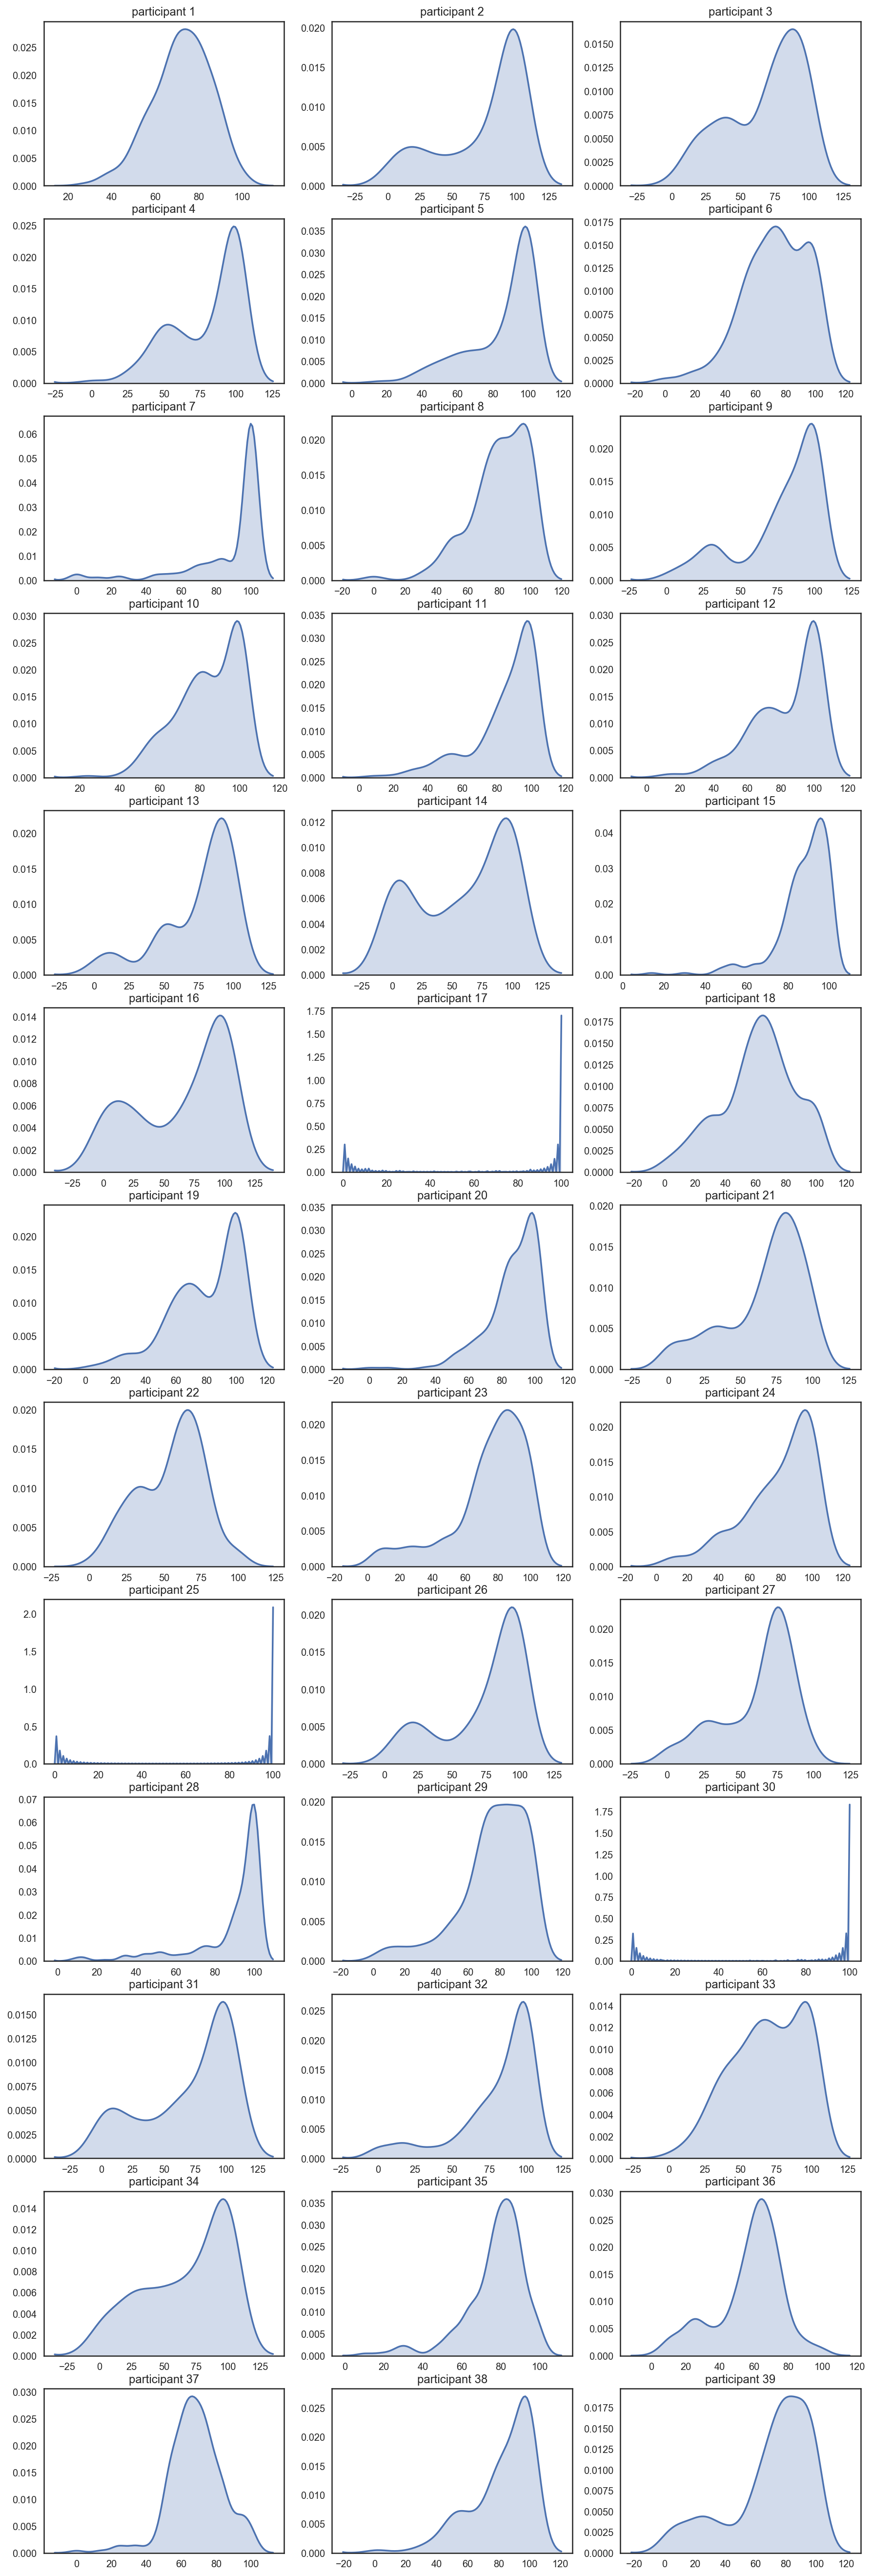

In [25]:
participant_densities(DataFrameSum1,'Conf')

## Choice RT distributions

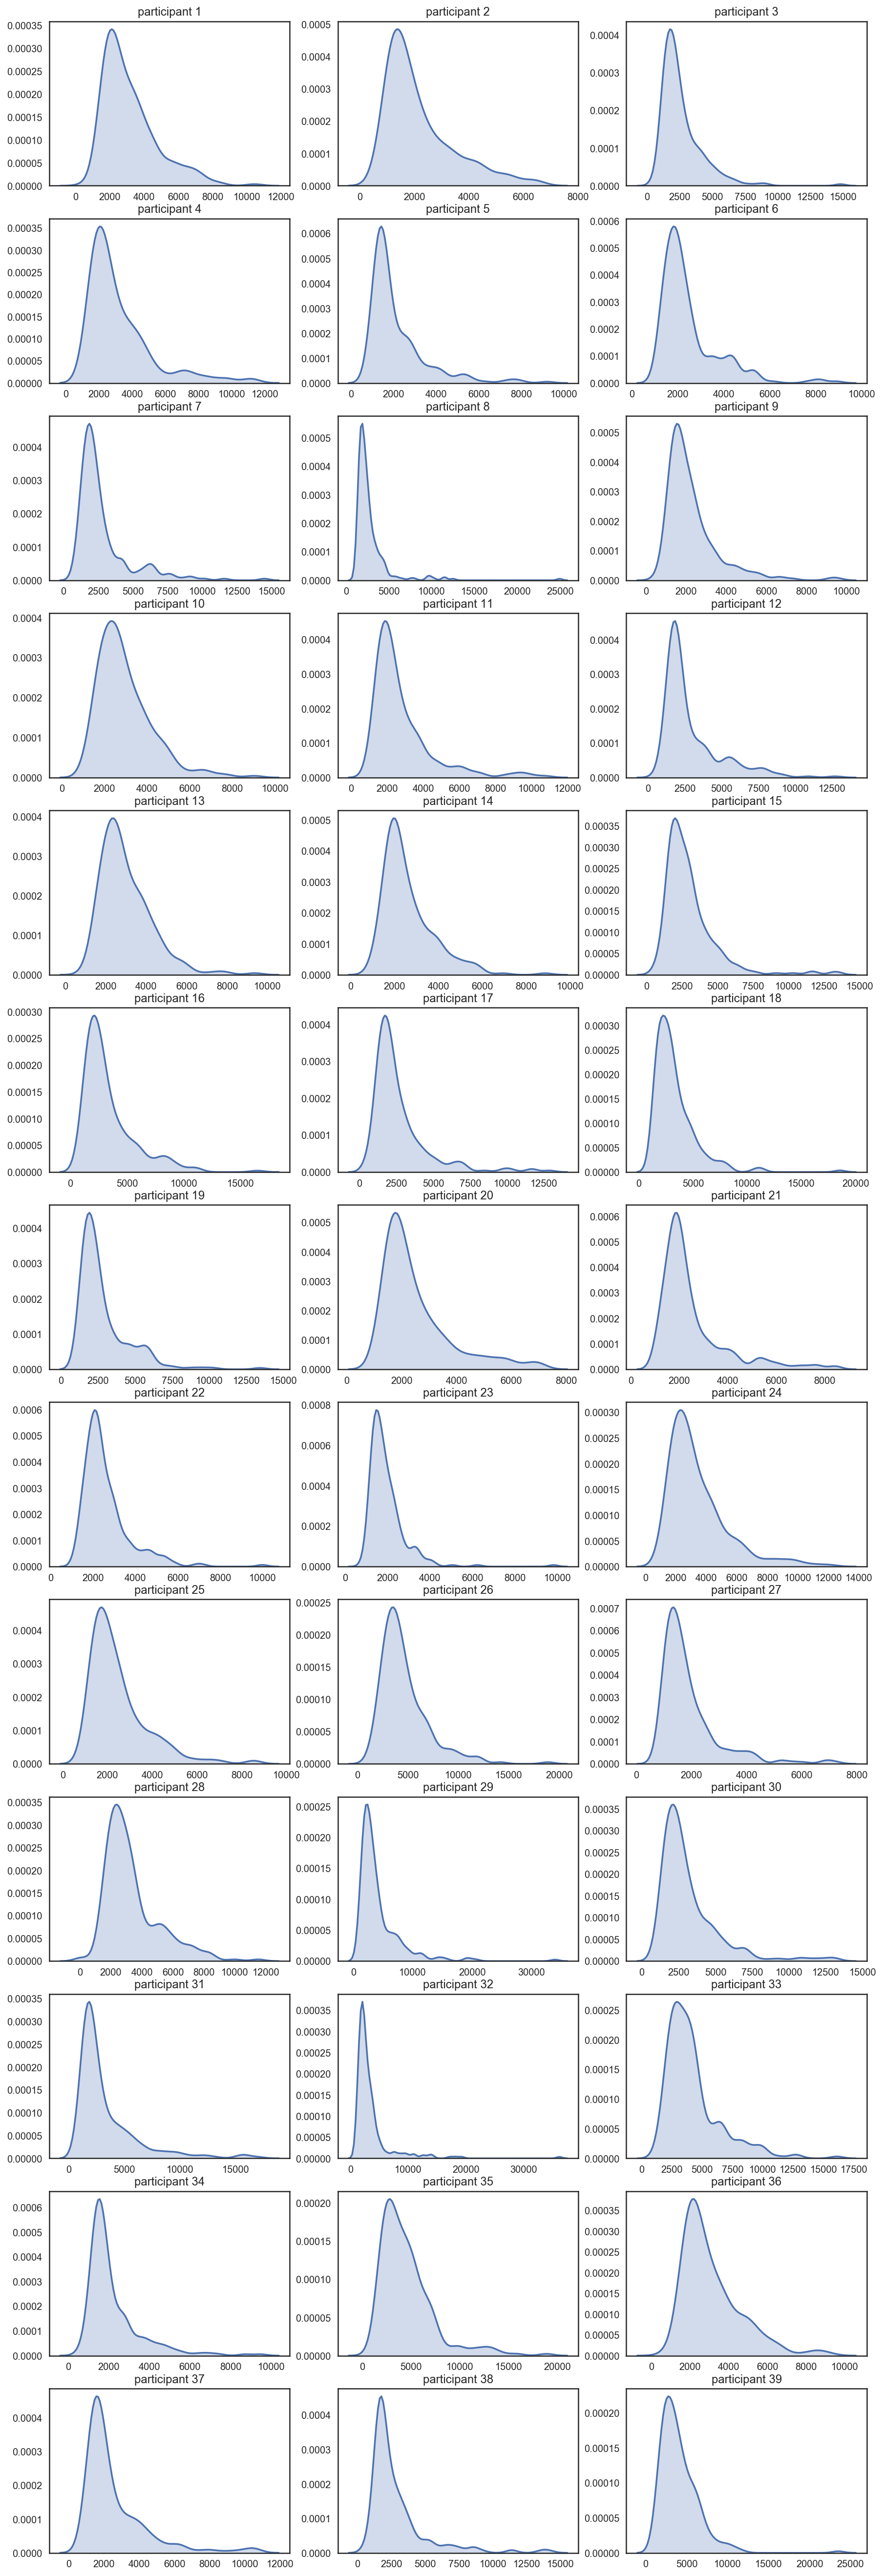

In [26]:
participant_densities(DataFrameSum1,'ChoiceRT',)

## Trial DDT distributions

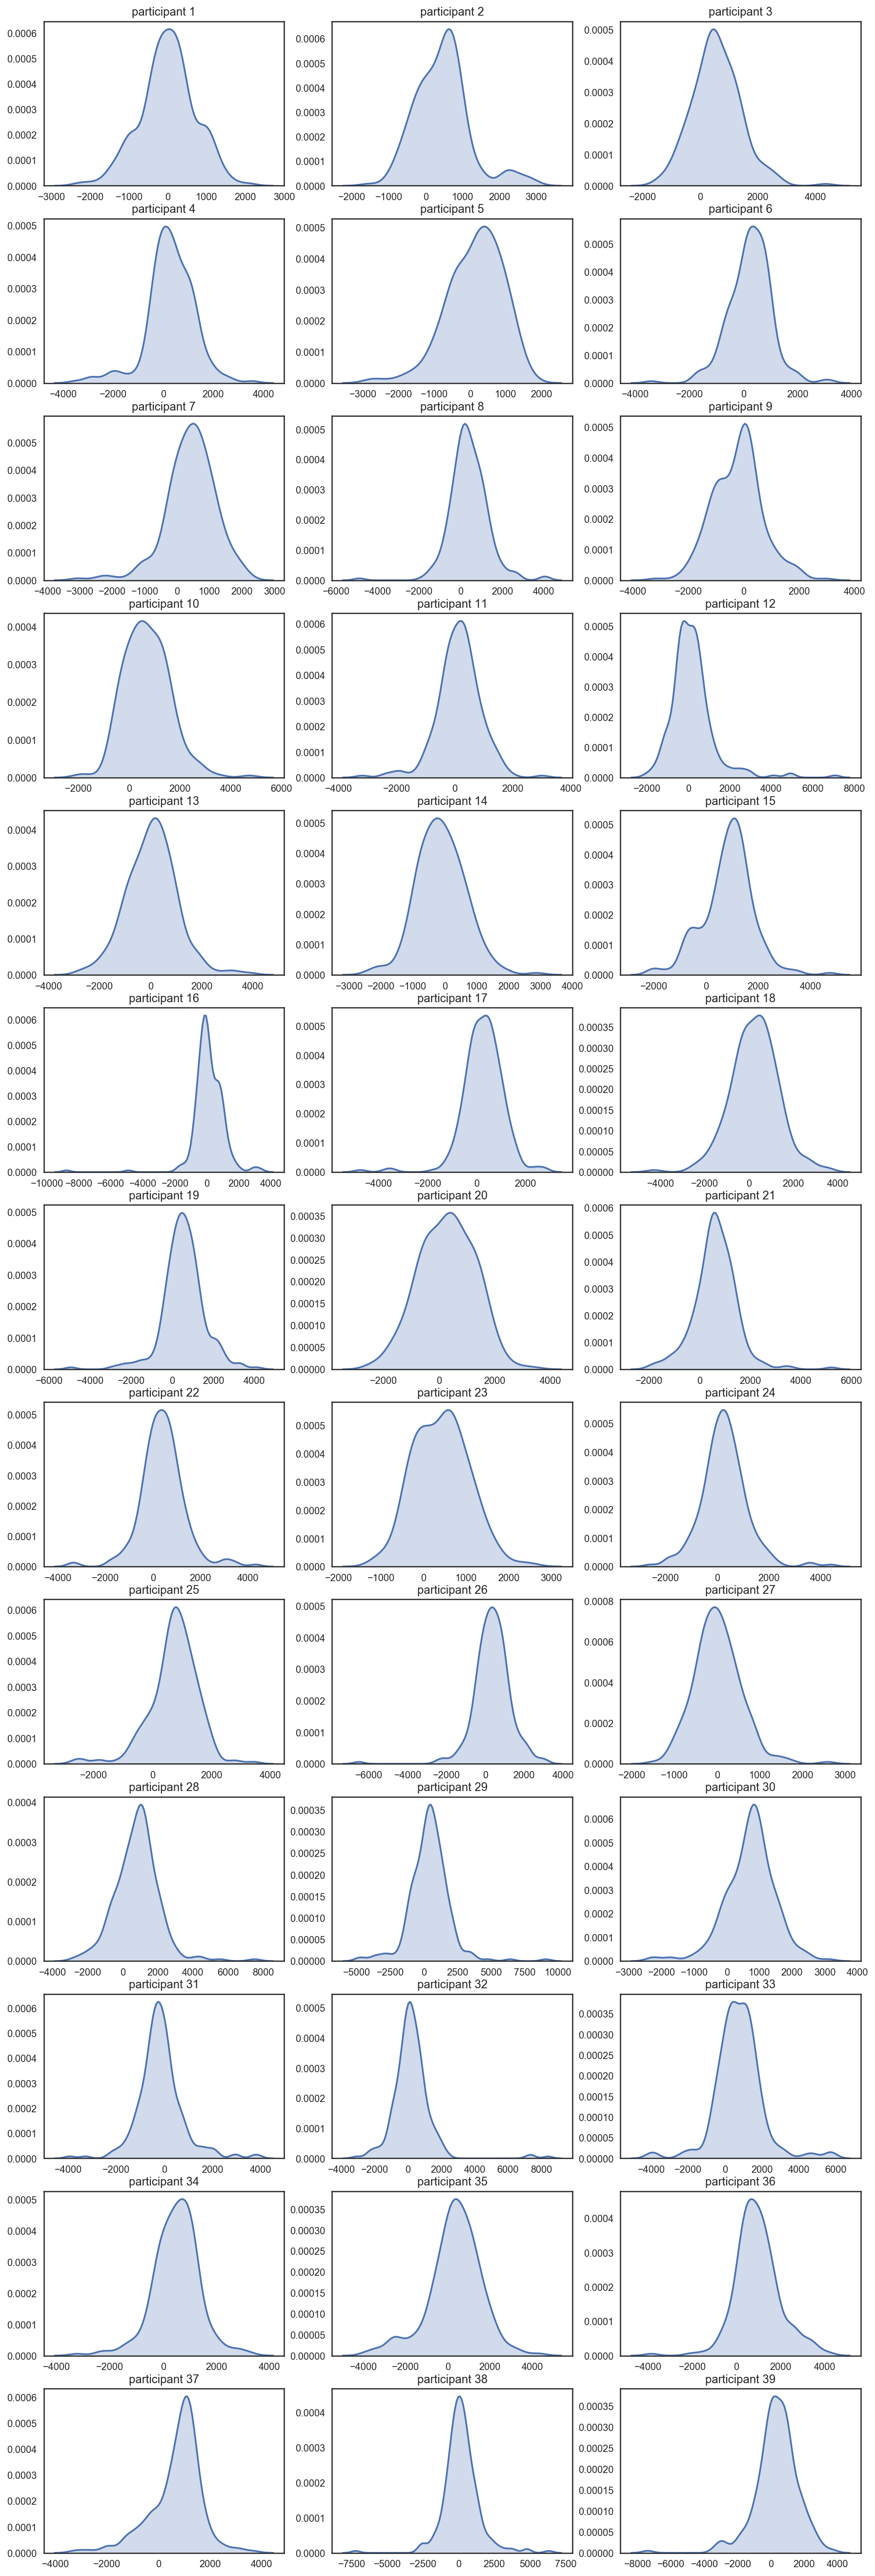

In [27]:
participant_densities(DataFrameSum1,'tDDT')

##  Item value distributions

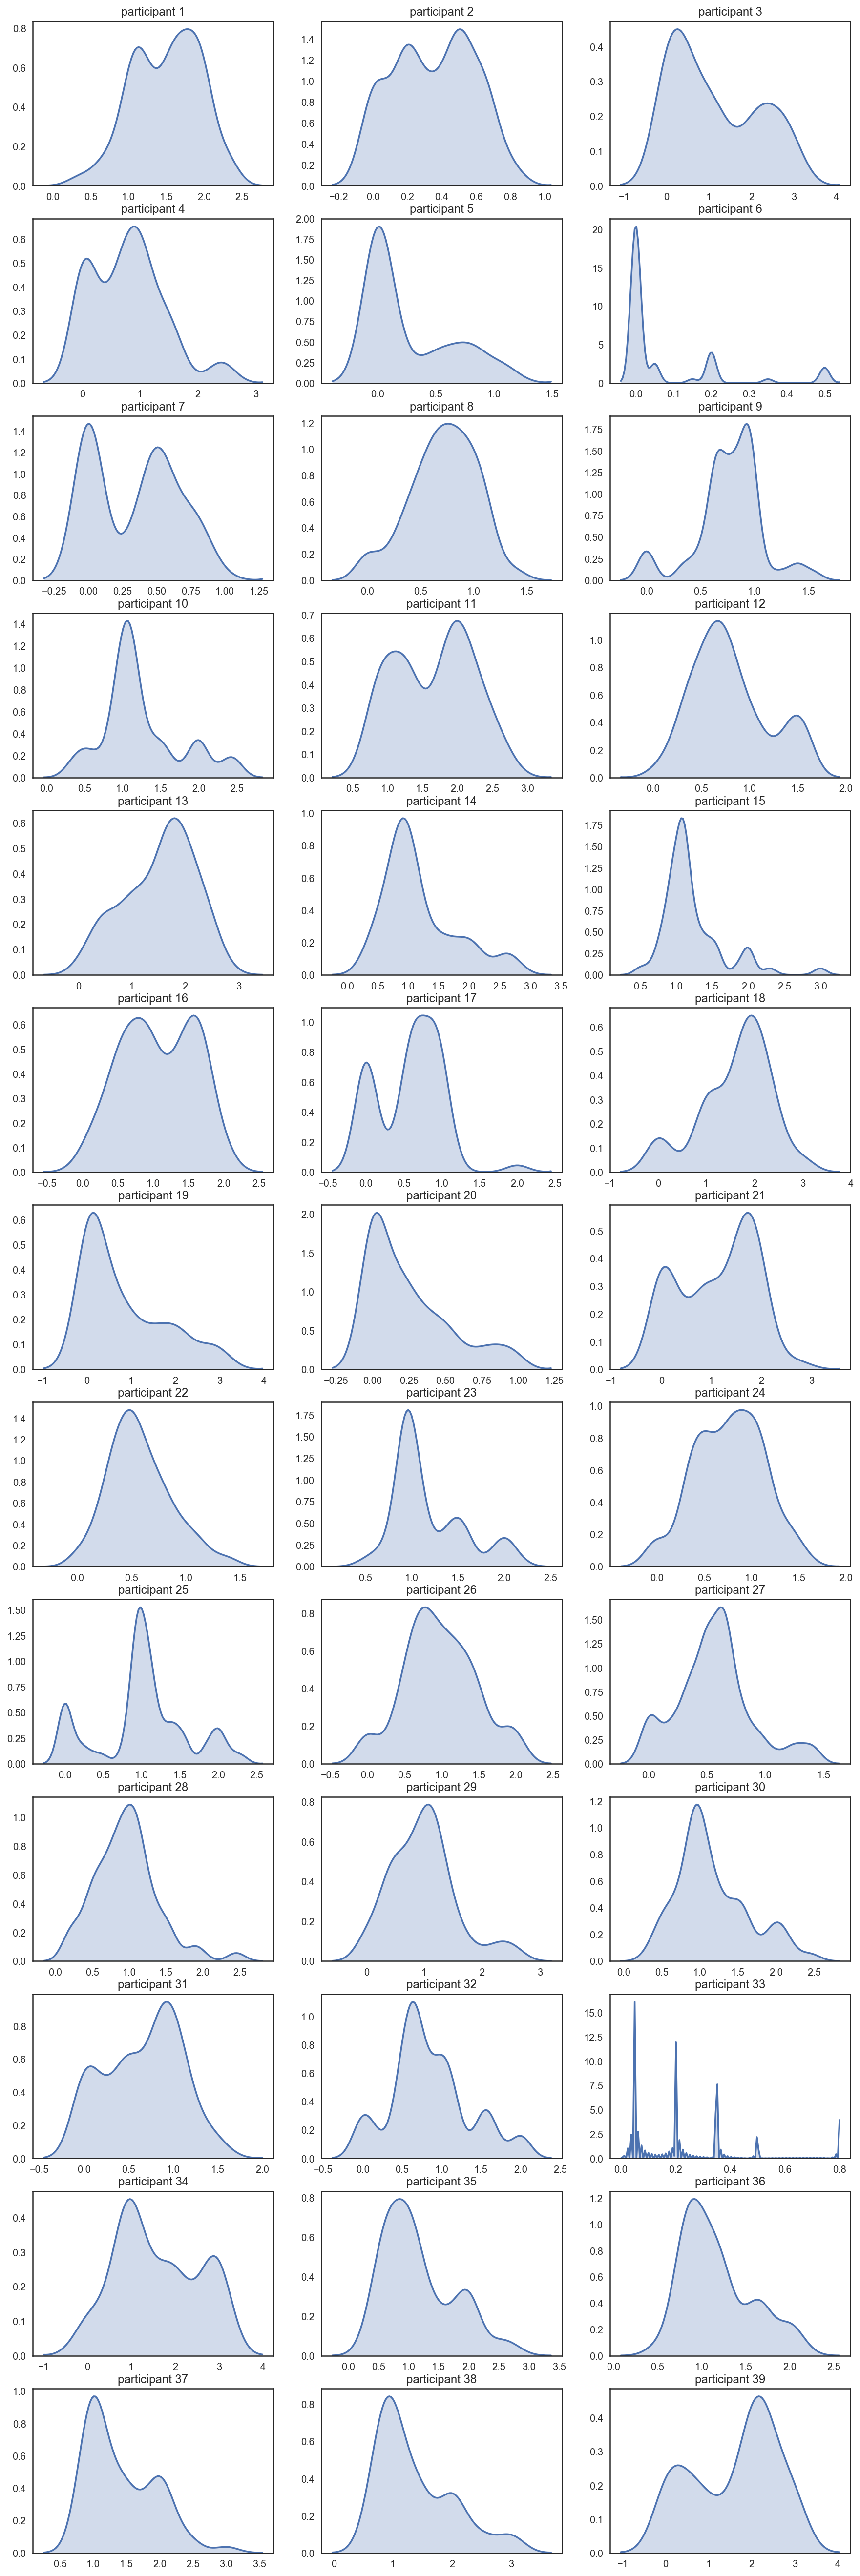

In [28]:
participant_densities(DataFrameSum1,'R_Value') # Distribution of value of items 
#(Right and left distributions are identical since we have the permutation)

## Trial GSF

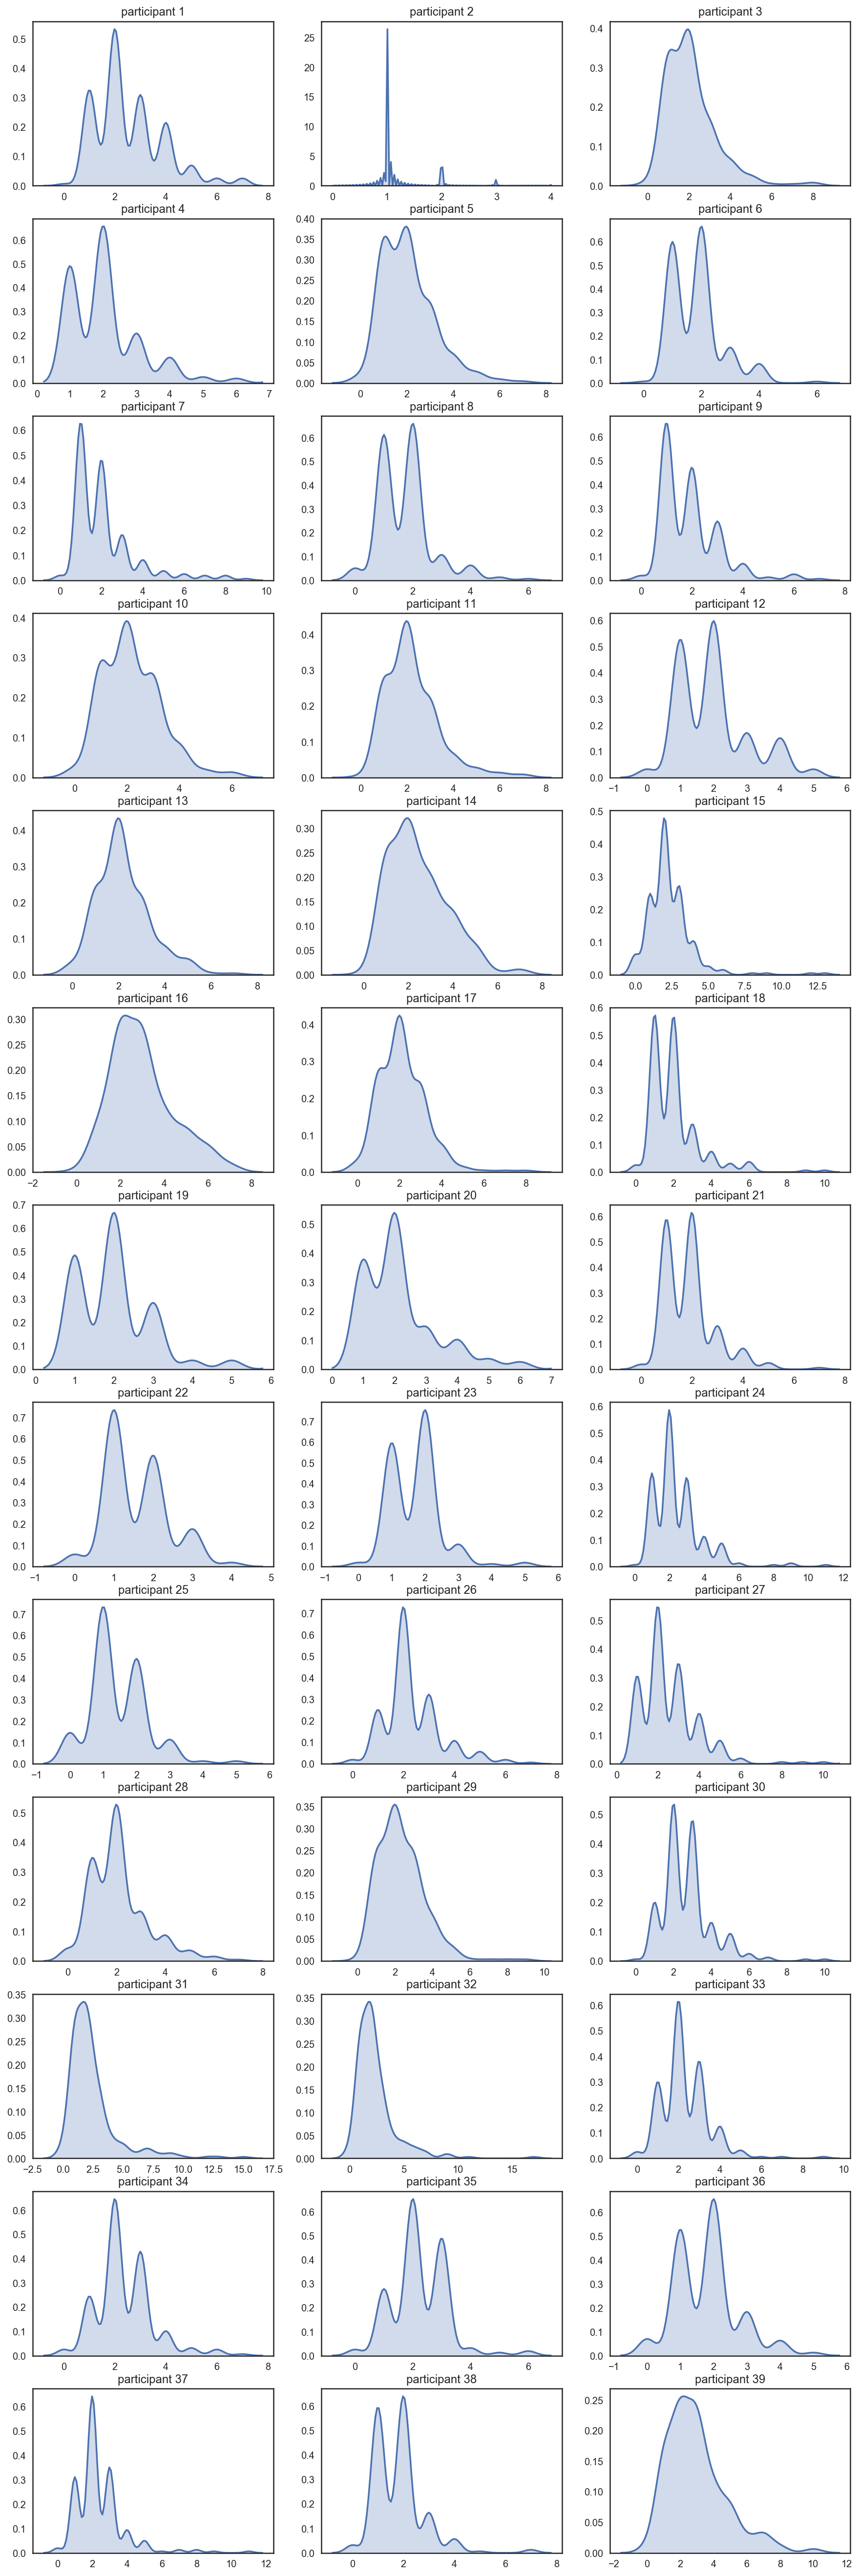

In [29]:
participant_densities(DataFrameSum1,'tGSF')

<a id='zfam'></a>
# Calculate Z-scores 

In [30]:
# Calculate Z-values and other 
z_matrix=[]
z_matrix_aux=[]

for i in (DataFrameSum1['Part'].unique()):
    Choicedata = DataFrameSum1.loc[DataFrameSum1['Part'] == str(i)]
    # from v3 and on we define DV as  RIGHT - LEFT values of the items
    pX_DV = - pd.to_numeric(Choicedata["L_Value"]) + pd.to_numeric(Choicedata["R_Value"])
    pX_zDV = (pX_DV - np.mean(pX_DV))/np.std(pX_DV)
    pX_absDV = abs(- pd.to_numeric(Choicedata['L_Value']) + pd.to_numeric(Choicedata['R_Value']))
    pX_zAbsDV = (pX_absDV - np.mean(pX_absDV))/np.std(pX_absDV)
    pX_zConf = (pd.to_numeric(Choicedata['Conf']) - np.mean(pd.to_numeric(Choicedata['Conf'])))/np.std(pd.to_numeric(Choicedata['Conf']))
    pX_zChoiceRT = (pd.to_numeric(Choicedata['ChoiceRT'] )- np.mean(pd.to_numeric(Choicedata['ChoiceRT'])))/np.std(pd.to_numeric(Choicedata['ChoiceRT']))
    
    
    z_matrix_aux= np.column_stack((pX_DV,pX_zDV,pX_absDV,pX_zAbsDV,pX_zConf,pX_zChoiceRT))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])

In [31]:
Final_trial = np.column_stack((DDT_GSF_trial,z_matrix))
Final_head = np.insert(Final_trial,  0, np.array(('Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat','DV','zDV','absDV','zAbsDV','zConf','zChoiceRT')), axis=0)
Final_head

array([['Part', 'TrialN', 'PairID', ..., 'zAbsDV', 'zConf', 'zChoiceRT'],
       ['1', '1', '14', ..., '1.5175525332012054',
        '-0.016205609317923964', '0.09811172039487039'],
       ['1', '2', '44', ..., '0.26452750578736517',
        '-0.3153860890334407', '0.15917416794981182'],
       ...,
       ['39', '238', '18', ..., '-1.2364620425235286',
        '1.0373498752733437', '-0.29323147365499813'],
       ['39', '239', '42', ..., '-1.2970729269609564',
        '1.1124521286867983', '0.49510045936709857'],
       ['39', '240', '54', ..., '0.3394209528495948',
        '0.9622476218598889', '-0.9156207887503862']], dtype='<U36')

In [32]:
#save text file with DDT and GSF for each participant/trial
#np.savetxt("DataFoodFramingNotebook_v1.csv", Final_head, delimiter=",", fmt='%s')

## Extract familiarity information from the BDM and add it to each trial in the choice step of the experiment

## Load data in python - Choice Data

In [33]:
#Load choice trial values (saved in previous stage)

#LOAD FROM FILE
#data_exp1 = pd.read_csv('/Users/bdmlab/Google Drive/BdM Projects/FoodFraming_Amy/Analysis Scripts/DataFoodFramingNotebook_v1.csv') # The main data file for the first

#CONTINUE USING DATASET FROM PREVIOUS STAGE
data_exp1 = pd.DataFrame(Final_trial,columns = ['Part', 'TrialN', 'PairID', 'L_Item', 'L_Value', 'R_Item', 'R_Value', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'L_IA_DT', 'R_IA_DT', 'tGSF','lastFixat','DV','zDV','absDV','zAbsDV','zConf','zChoiceRT'])

data_exp1.head()

Part TrialN PairID                        L_Item L_Value  \
0    1      1     14        116_boots_caramels.png    0.95   
1    1      2     44  102_propercorn_worcester.png     2.3   
2    1      3     51               59_crunchie.png     1.7   
3    1      4     12       64_nestle_aero_mint.png    1.55   
4    1      5      4   44_walkers_french_fries.png     2.0   

                           R_Item R_Value ChosenITM ChoiceRT Conf  \
0               31_beef_jerky.png     2.0         1     3327   72   
1                   26_yorkie.png     1.7         1     3424   68   
2                 5_caramello.png    1.25         1     3691   68   
3    102_propercorn_worcester.png     2.3         0     8144   68   
4  111_propercorn_sweetnsalty.png     2.0         0     6559   88   

          ...          L_IA_DT R_IA_DT tGSF lastFixat                    DV  \
0         ...             1874    1186    3         1                  1.05   
1         ...             1206    1770    3         2   -0.5999999999999999   
2         ...             1020    2091    1         2  -0.44999999999999996   
3         ...             4153    2660    4         1    0.7499999999999998   
4         ...             4063    2024    4         1                   0.0   

                      zDV                absDV                zAbsDV  \
0      1.6944302139657446                 1.05    1.5175525332012054   
1     -0.9682458365518538   0.5999999999999999   0.26452750578736517   
2     -0.7261843774138904  0.44999999999999996  -0.15314750335058117   
3       1.210307295689817   0.7499999999999998    0.6822025149253115   
4  1.0451085762029445e-17                  0.0   -1.4061725307644208   

                   zConf            zChoiceRT  
0  -0.016205609317923964  0.09811172039487039  
1    -0.3153860890334407  0.15917416794981182  
2    -0.3153860890334407   0.3272532761680527  
3    -0.3153860890334407     3.13046027577789  
4     1.1805163095441429    2.132687292534775  

[5 rows x 23 columns]

In [34]:
len(data_exp1)

9360

## Load data in python - BDM data

In [35]:
#Extract BDM data from all the subject folders (Separated folder for each participant, each one containing the file "BDM_RESULTS_FILE.txt")

#INPUT PATH FOR BDM_RESULTS_FILE folder
main_path = "/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/"
file_list = os.listdir(main_path)

print("File List in Folder")
print(sorted(file_list))

File List in Folder
['.DS_Store', 'p1', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p5', 'p6', 'p7', 'p8', 'p9']


In [36]:
file_array = []

for k in range(len(participant_names)):
        BDM_filename = "/BDM_RESULTS_FILE.txt"
        files =  main_path + participant_names[k] + BDM_filename
        file_array.append(files) 
        
print("number of files to load:" ,len(file_array))        
file_array
#Make sure that the paths are properly defined 

number of files to load: 39


['/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p1/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p5/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p6/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p7/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p8/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p9/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue/Food Framing Data Raw/p10/BDM_RESULTS_FILE.txt',
 '/Users/bdmlab/OneDrive - University College London/PhD Projects/FoodFramingValue

In [37]:
#define partipant names(numbers)
participant = (data_exp1['Part'].unique())
participant

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39'], dtype=object)

### Adding familiarity values and new variables

In [38]:
FamLeft  = []
FamRight = []
Tot_Fam = []
FamChosen = []
FamUnChosen = []
ValChosen = []
ValUnChosen = []
Tot_Val = []
Correct_val = []
correct = []

trial_count = 0

#for cycle for participant
for k in range(0,len(file_array)):
    BDMframe = [pd.read_csv(file_array[k], sep="\t")]
    BDMdata = pd.concat(BDMframe)
    
    #for cycle for trials 
    data_part = data_exp1.loc[(data_exp1['Part'] == str(participant[k]))]
    trial_n = data_part['TrialN'].unique()
    #print(data_part)

    for  j in range(len(trial_n)):    
        #Pick identity left item  
    
        L_item_name = data_part['L_Item'][trial_count]
        FamValue_L = BDMdata.loc[(BDMdata['BDM_ITM']== L_item_name),'BDM_FAM'].values[0]
        Value_L = BDMdata.loc[(BDMdata['BDM_ITM']== L_item_name),'BDM_VAL'].values[0]
        
        #Pick identity right item
        
        R_item_name = data_part['R_Item'][trial_count]
        FamValue_R = BDMdata.loc[(BDMdata['BDM_ITM']== R_item_name),'BDM_FAM'].values[0]
        Value_R = BDMdata.loc[(BDMdata['BDM_ITM']== R_item_name),'BDM_VAL'].values[0]
        
        
        ChosenITMtrial = data_part['ChosenITM'][trial_count]
        BlockCondtrial = data_part['BlockCond'][trial_count]

        if ChosenITMtrial == "1":  #Selected Item is Right
            FamChosenT  = FamValue_R
            FamUnChosenT  = FamValue_L
            ValUnChosenT  = Value_L
            ValChosenT  = Value_R
            
            if BlockCondtrial == "1.0": # Block is like, correct chosen is higher value
                if Value_R >= Value_L:
                    correct = 1
                else: 
                    correct = 0
            
            if BlockCondtrial == "2.0" :# Block is dislike, correct chosen is lower value
                if Value_L >= Value_R:
                    correct = 1
                else: 
                    correct = 0  
                
        else: # Selected item is Left
            FamChosenT  = FamValue_L
            FamUnChosenT  = FamValue_R
            ValUnChosenT  = Value_R           
            ValChosenT = Value_L
            
            if BlockCondtrial == "1.0": # Block is like, correct chosen is higher value
                if Value_L >= Value_R:
                    correct = 1
                else: 
                    correct = 0
            
            if BlockCondtrial == "2.0" :# Block is dislike, correct chosen is lower value
                if Value_R >= Value_L:
                    correct = 1
                else: 
                    correct = 0  
        
        FamValTot = FamValue_L + FamValue_R
        
        ValTot = Value_L + Value_R
        
        #add to the rows with current trial measures
        FamLeft.append(str(FamValue_L))
        FamRight.append(str(FamValue_R))
        Tot_Fam.append(str(FamValTot))
        Tot_Val.append(str(ValTot))    
        FamChosen.append(str(FamChosenT))
        FamUnChosen.append(str(FamUnChosenT))
        ValChosen.append(str(ValChosenT))
        ValUnChosen.append(str(ValUnChosenT))
        Correct_val.append(str(correct))

        trial_count = trial_count + 1
        


#### Stack columns for the new familiarity values

In [39]:
table_aux= np.column_stack((FamLeft,FamRight,Tot_Fam,Tot_Val,FamChosen,FamUnChosen,ValChosen,ValUnChosen,Correct_val))
table_aux

array([['1.08', '4.83', '5.91', ..., '2.0', '0.95', '0'],
       ['4.83', '3.58', '8.41', ..., '1.7', '2.3', '1'],
       ['5.0', '2.83', '7.83', ..., '1.25', '1.7', '1'],
       ...,
       ['5.0', '5.0', '10.0', ..., '0.05', '0.0', '1'],
       ['5.0', '5.0', '10.0', ..., '2.45', '2.45', '1'],
       ['2.08', '5.0', '7.08', ..., '0.95', '2.3', '0']], dtype='<U19')

In [40]:
# Check similar size in both tables
print(len(table_aux))
print(len(data_exp1))

9360
9360


In [41]:
Fam_part = pd.DataFrame(table_aux,columns=['FamLeft','FamRight','Tot_Fam','Tot_Val','FamChosen','FamUnChosen','ValChosen','ValUnChosen','Correct'])
new_data = pd.concat([data_exp1, Fam_part],axis =1)

# Agregate data matrix
new_data = new_data.apply(pd.to_numeric, errors='ignore')

z_matrix=[]
z_matrix_aux=[]

#### Calculate Z-values for familiarity and (un)Chosen values

In [42]:
for i in unique(new_data["Part"]):
    Choicedata = new_data.loc[new_data['Part'] == i]
    pX_totFam = pd.to_numeric(Choicedata['Tot_Fam'])
    z_totFam = (pX_totFam - np.mean(pX_totFam))/np.std(pX_totFam)

    pX_totVal = pd.to_numeric(Choicedata['Tot_Val'])
    z_totVal = (pX_totVal - np.mean(pX_totVal))/np.std(pX_totVal)
    
    pX_ValChosen = pd.to_numeric(Choicedata['ValChosen'])
    z_ValChosen = (pX_ValChosen - np.mean(pX_ValChosen))/np.std(pX_ValChosen)

    pX_ValUnChosen = pd.to_numeric(Choicedata['ValUnChosen'])
    z_ValUnChosen = (pX_ValUnChosen - np.mean(pX_ValUnChosen))/np.std(pX_ValUnChosen)

    pX_FamChosen = pd.to_numeric(Choicedata['FamChosen'])
    z_FamChosen = (pX_FamChosen - np.mean(pX_FamChosen))/np.std(pX_FamChosen)

    pX_FamUnChosen = pd.to_numeric(Choicedata['FamUnChosen'])
    z_FamUnChosen = (pX_FamUnChosen - np.mean(pX_FamUnChosen))/np.std(pX_FamUnChosen)
    
    pX_tGSF = pd.to_numeric(Choicedata['tGSF'])
    z_tGSF = (pX_tGSF - np.mean(pX_tGSF))/np.std(pX_tGSF)
    
    pX_tDDT = pd.to_numeric(Choicedata['tDDT'])
    z_tDDT = (pX_tDDT - np.mean(pX_tDDT))/np.std(pX_tDDT)

    absDDT = abs(z_tDDT)
    
    z_matrix_aux= np.column_stack((z_totFam,z_totVal,z_ValChosen,z_ValUnChosen,z_FamChosen,z_FamUnChosen, z_tGSF, z_tDDT, absDDT))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])

In [43]:
Zmatrix_part = pd.DataFrame(z_matrix,columns=['ZtotFam','ZtotVal','ZValCh','ZValUnCh','ZFamCh','ZFamUnCh', 'ztGSF', 'ztDDT', 'absDDT'])

<a id='split'></a>
# Including Median Split Data

#### Calculate median split for each participant and block conditions separatedly. 
#### We apply a split separating participants and block conditions

### Insert the name of the variables to be used for the median split

In [44]:
Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit']
Splits_variables = ['Conf', 'tGSF','tDDT']

In [45]:
median_matrix=[]
median_matrix_aux=[]
median_matrix_aux_cond=[]
Split_cols = []

for h in range(len(Splits_variables)):
    median_matrix=[]
    for i in unique(new_data["Part"]):
        median_matrix_aux=[]

        for j in unique(new_data["BlockCond"]):
            #median_matrix_aux_cond=[]

            #Extract data by participant and BlockCond (1: Like, 2: Dislike)
            Splitdata = new_data.loc[new_data['Part'] == i]
            Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
            
            # Select the column to split
            Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]]]
            SplitSort = Splitdata.values
            # Sort for confidence column
            SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
            #print(SplitSort)
            lenPart = len(Splitdata)
            #print(lenPart)
            # Generate column with median order
            median_low = [0] * int (lenPart/2)
            #print (median_low)
            median_high = [1] * int (lenPart/2)
            #print (median_high)
            median_split_order = median_low + median_high
            #Attach split median order column (1 and 0)
            median_aux= np.column_stack((SplitSort,median_split_order))
            #Sort back to trial number
            SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
            #print(len(SplitSorted))
            
            for kk in range(len(SplitSorted)): 
                if len(median_matrix_aux) == 0 :
                    median_matrix_aux = SplitSorted[0]
                else:
                    median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
        
        #print(len(median_matrix_aux))
        # sort after adding both conditions    
        median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
        
        #Extract only the column with the median split information
        median_matrix_aux = median_matrix_aux[:,2]
        
        #append to median matrix for the participants
        for k in range(len(median_matrix_aux)):    
            median_matrix.append(median_matrix_aux [k])
    
    median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
    #print(len (median_matrix))
    #add new column (new split variable columns) to the split matrix
    if  h == 0:
        Split_cols = median_matrix
    else:
        Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)


        

In [46]:
#Join new familiarity and split datasets with the old trial information
data_exp1 = pd.concat([new_data, Zmatrix_part, Split_cols],axis =1)

#save text file with DDT and GSF for each participant/trial
data_exp1.to_csv("Output/DataFoodFramingNotebook_v1.csv")

<a id='PartEx'></a>
# Participant Exclusion
---------------------------------------------------------------------------------------

##  Exclusion Criteria
### As used in Folke et al. (2016)

#### (1) Participants used less than 25% of the BDM scale.
#### (2) Participants gave exactly the same BDM rating for more than 25% of the items.  [For our study adapted to 50%]
#### (3) Participants used less than 25% of the confidence scale.
#### (4) Participants gave exactly the same confidence rating for more than 25% of their choices. [For our study adapted to 50%]
#### (*) adpted values to avoid eliminating too many participants from our study. Additionally, we consider that our slider moves in bigger jumps than the one used by Tomas.


In [47]:
ExclusionMatrix = []
#for cycle for participant
for k in range(0,len(file_array)):
 
    # Checking for values 
    BDMframe = [pd.read_csv(file_array[k], sep="\t")]
    BDMframe = pd.concat(BDMframe)
    BDMvalue = BDMframe['BDM_VAL']
    ValueRange = max(BDMvalue) - min(BDMvalue)
    ValueCounts = BDMvalue.value_counts()
    maxValueCounts = max(ValueCounts)
    ValueCountsTotal = sum(int(i) for i in ValueCounts.values)
    
    PropnMostFreqVal = maxValueCounts / ValueCountsTotal
    PropnRangeVal = ValueRange / 3
    
    # Checking for confidence
    participant_data = data_exp1.loc[ (data_exp1['Part'] == k+1)]
    ConfidencePart =   participant_data ['Conf']
    
    ConfRange = max(ConfidencePart) - min(ConfidencePart)
    ConfCounts = ConfidencePart.value_counts()
    
    maxConfCounts = max(ConfCounts)
    ConfCountsTotal = sum(int(i) for i in ConfCounts.values)
    
    PropnMostFreqConf = maxConfCounts / ConfCountsTotal
    PropnRangeConf = ConfRange / 100

    
    ExclusionMatrix.append([k+1 , PropnMostFreqVal, PropnRangeVal, PropnMostFreqConf, PropnRangeConf]) 

#ExclusionMatrix=pd.DataFrame(ExclusionMatrix,columns=['Participant', 'ProportionMostFrequentBid', 'ProportionRangeBid','ProportionMostFrequentConfidence', 'ProportionRangeConfidence])

##### ProportionMostFrequentBid : the proportion of all the BDM bids that were reported with the most frequent price (0: no repetition, 1: all items received the same bid price )
##### ProportionRangeBid : proportion of the whole range (£0 - £3) that was covered by the reported BDM bid price (0: no range, 1: whole range covered)
##### ProportionMostFrequentConfidence : the proportion of all the confidence values (during the CHOICE STAGE) that has been reported with a single (most frequent) value (0: no repetition, 1: all items received the same confidence value )
##### ProportionRangeConfidence : proportion of the whole range (0 - 100) that was covered by the confidence values (0: no range, 1: whole range covered)

In [48]:
ExclusionMatrix=pd.DataFrame(ExclusionMatrix,columns=['Participant', 'ProportionMostFrequentBid', 'ProportionRangeBid','ProportionMostFrequentConfidence', 'ProportionRangeConfidence'])
ExclusionMatrix

Participant  ProportionMostFrequentBid  ProportionRangeBid  \
0             1                   0.174603            0.650000   
1             2                   0.222222            0.266667   
2             3                   0.174603            1.000000   
3             4                   0.174603            0.816667   
4             5                   0.492063            0.366667   
5             6                   0.666667            0.166667   
6             7                   0.380952            0.316667   
7             8                   0.206349            0.466667   
8             9                   0.301587            0.516667   
9            10                   0.317460            0.700000   
10           11                   0.142857            0.650000   
11           12                   0.190476            0.500000   
12           13                   0.142857            0.900000   
13           14                   0.190476            0.800000   
14           15                   0.317460            0.850000   
15           16                   0.142857            0.666667   
16           17                   0.285714            0.666667   
17           18                   0.158730            1.000000   
18           19                   0.238095            1.000000   
19           20                   0.301587            0.316667   
20           21                   0.190476            0.916667   
21           22                   0.238095            0.466667   
22           23                   0.460317            0.600000   
23           24                   0.174603            0.516667   
24           25                   0.253968            0.766667   
25           26                   0.158730            0.666667   
26           27                   0.269841            0.566667   
27           28                   0.174603            0.800000   
28           29                   0.174603            0.866667   
29           30                   0.269841            0.700000   
30           31                   0.174603            0.516667   
31           32                   0.238095            0.666667   
32           33                   0.730159            0.266667   
33           34                   0.285714            1.000000   
34           35                   0.158730            0.800000   
35           36                   0.238095            0.550000   
36           37                   0.222222            0.733333   
37           38                   0.206349            0.783333   
38           39                   0.142857            1.000000   

    ProportionMostFrequentConfidence  ProportionRangeConfidence  
0                           0.087500                       0.72  
1                           0.400000                       1.00  
2                           0.112500                       1.00  
3                           0.454167                       1.00  
4                           0.445833                       0.86  
5                           0.166667                       1.00  
6                           0.679167                       1.00  
7                           0.204167                       1.00  
8                           0.387500                       1.00  
9                           0.337500                       0.76  
10                          0.316667                       0.92  
11                          0.483333                       0.88  
12                          0.145833                       1.00  
13                          0.254167                       1.00  
14                          0.166667                       0.86  
15                          0.387500                       1.00  
16                          0.804167                       1.00  
17                          0.104167                       1.00  
18                          0.429167                       0.96  
19                          0.316667       

### Excluded Participants

#### -Participant 6 excluded by criteria (1)
#### -Participant 33 excluded by criteria (2)
#### -NO participants excluded by criteria (3)
#### -Participants 7, 17, 25, 30  excluded by criteria (4)


In [49]:
for i in [6, 7, 17, 25, 30, 33]:
    data_exp1 = data_exp1[(data_exp1.Part != i)]
data_exp1["Part"].unique()

#33 has problems for the logistic regression

array([ 1,  2,  3,  4,  5,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 38, 39])

In [342]:
len(data_exp1["Part"].unique())

33

#### *Additionally, it was checked that trials in which participants did not fixate in any of the items were were skipped (trials fulfiling this criteria were found only in participant 'p40.edf')*

# Data Analysis 
-------------------------------------------

## Load data from preparation step

In [50]:
figsize(15, 15)
#Transform to numeric values in the dataframe
data_exp1 = data_exp1.apply(pd.to_numeric, errors='ignore')
#data_exp1.head()
#Show the list of data columns
list(data_exp1)

['Part',
 'TrialN',
 'PairID',
 'L_Item',
 'L_Value',
 'R_Item',
 'R_Value',
 'ChosenITM',
 'ChoiceRT',
 'Conf',
 'ConfRT',
 'BlockCond',
 'tDDT',
 'L_IA_DT',
 'R_IA_DT',
 'tGSF',
 'lastFixat',
 'DV',
 'zDV',
 'absDV',
 'zAbsDV',
 'zConf',
 'zChoiceRT',
 'FamLeft',
 'FamRight',
 'Tot_Fam',
 'Tot_Val',
 'FamChosen',
 'FamUnChosen',
 'ValChosen',
 'ValUnChosen',
 'Correct',
 'ZtotFam',
 'ZtotVal',
 'ZValCh',
 'ZValUnCh',
 'ZFamCh',
 'ZFamUnCh',
 'ztGSF',
 'ztDDT',
 'absDDT',
 'ConfSplit',
 'GSFMedSplit',
 'DDTMedSplit']

<a id='corr'></a>
#  Correlation Plots  

## (Like + Dislike) conditions

### Insert the variables to calculate the correlation

In [51]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

Pearson's r = 0.189 p =  0.0


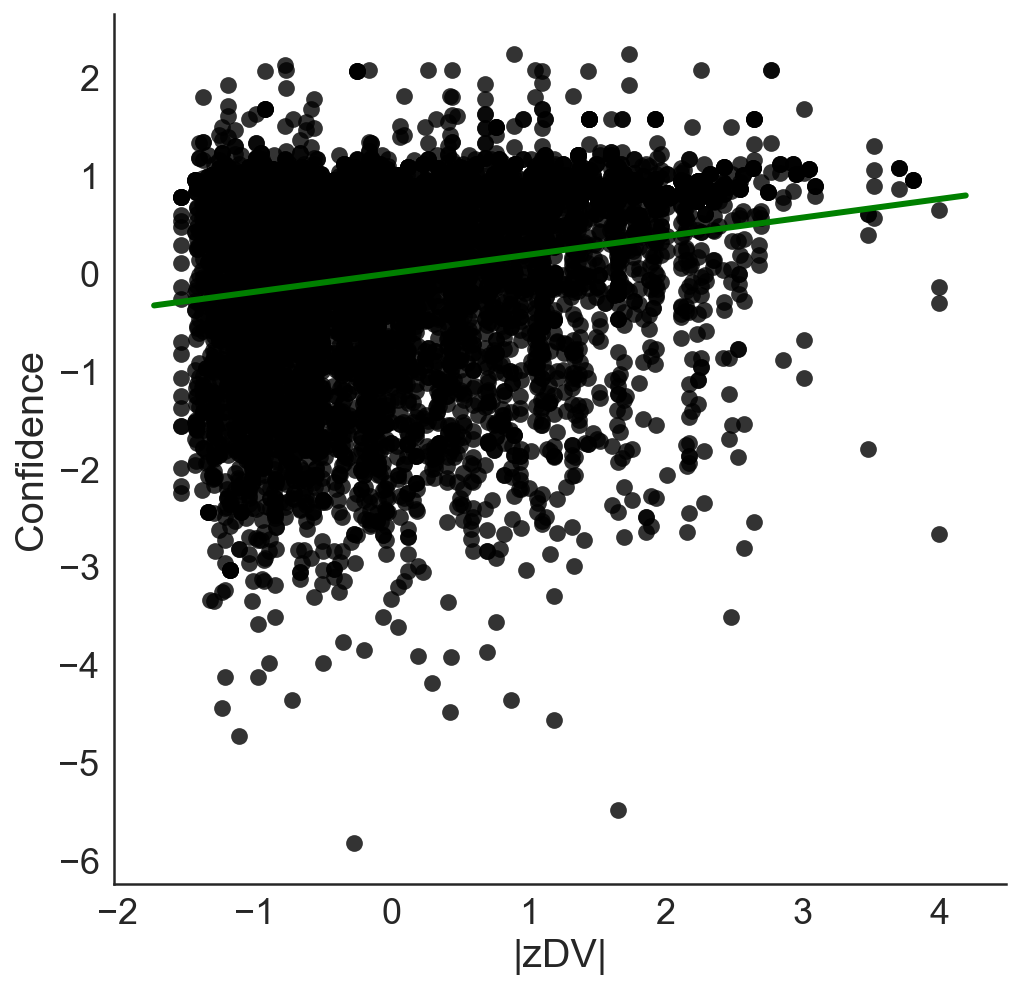

In [52]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_exp1[x_variable]
y=data_exp1[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Green', lw=3)
sns.despine()

results = pearsonr(data_exp1[x_variable], data_exp1[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

## Like Condition Only

In [53]:
#Select Condition 
data_expL = data_exp1.loc[data_exp1['BlockCond'] == 1] # 1 = Like, 2 = Dislike


### Insert the variables to calculate the correlation

In [54]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

Pearson's r = 0.192 p =  0.0


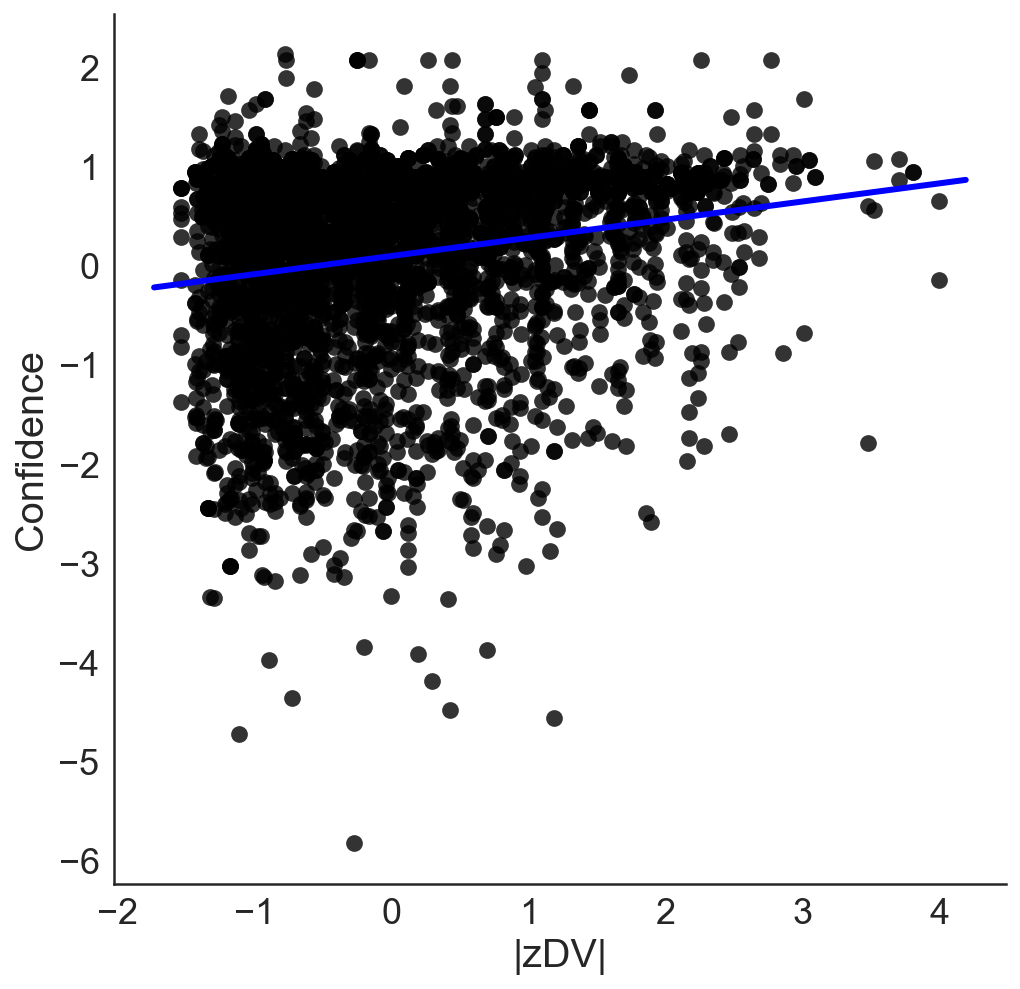

In [55]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_expL, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expL[x_variable]
y=data_expL[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Blue', lw=3)
sns.despine()

results = pearsonr(data_expL[x_variable], data_expL[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

## Dislike Condition Only

In [56]:
data_expD = data_exp1.loc[data_exp1['BlockCond'] == 2] # 1 = Like, 2 = Dislike

### Insert the variables to calculate the correlation

In [57]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

Pearson's r = 0.19 p =  0.0


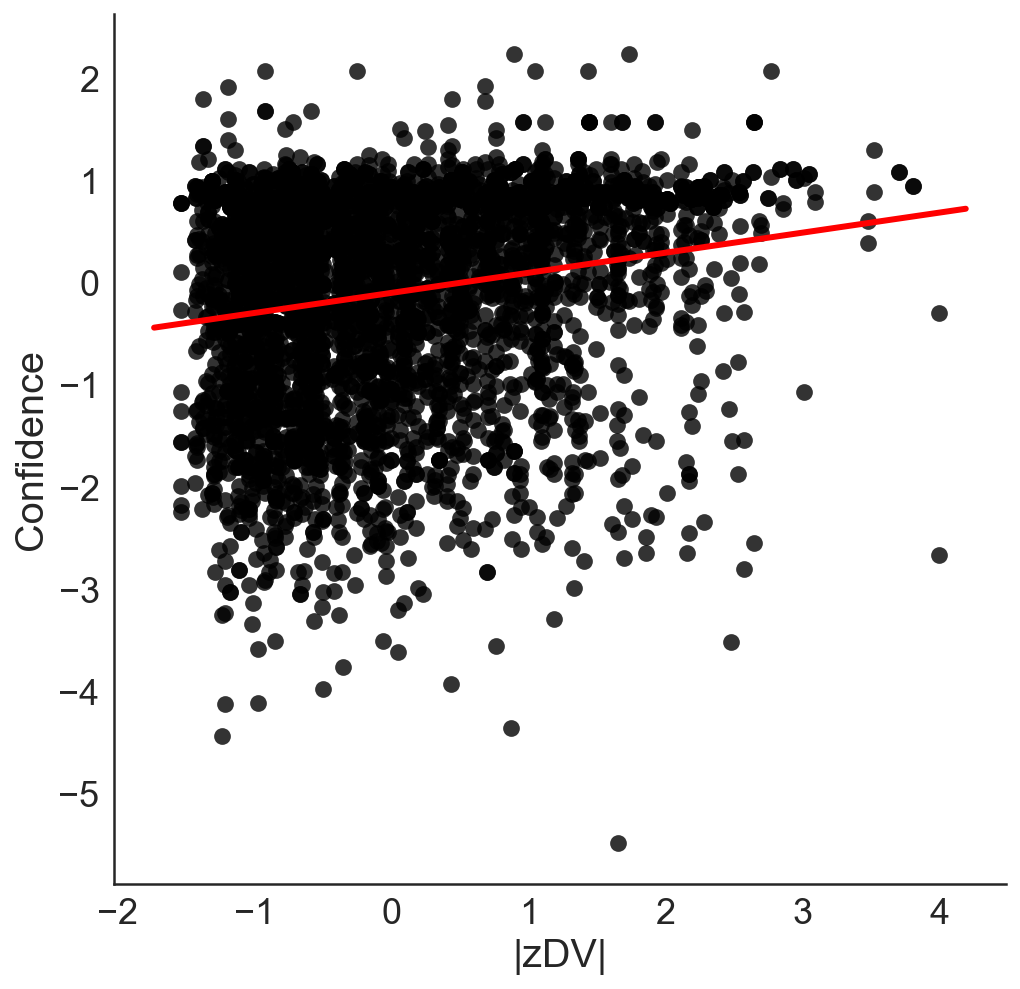

In [58]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_expD, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expD[x_variable]
y=data_expD[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Red', lw=3)
sns.despine()

results = pearsonr(data_expD[x_variable], data_expD[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

<a id='log'></a>
# Logistic Plots

### Difference in value (DV) is calculated as (Value_Right  - Value_Left)

## Like Condition

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


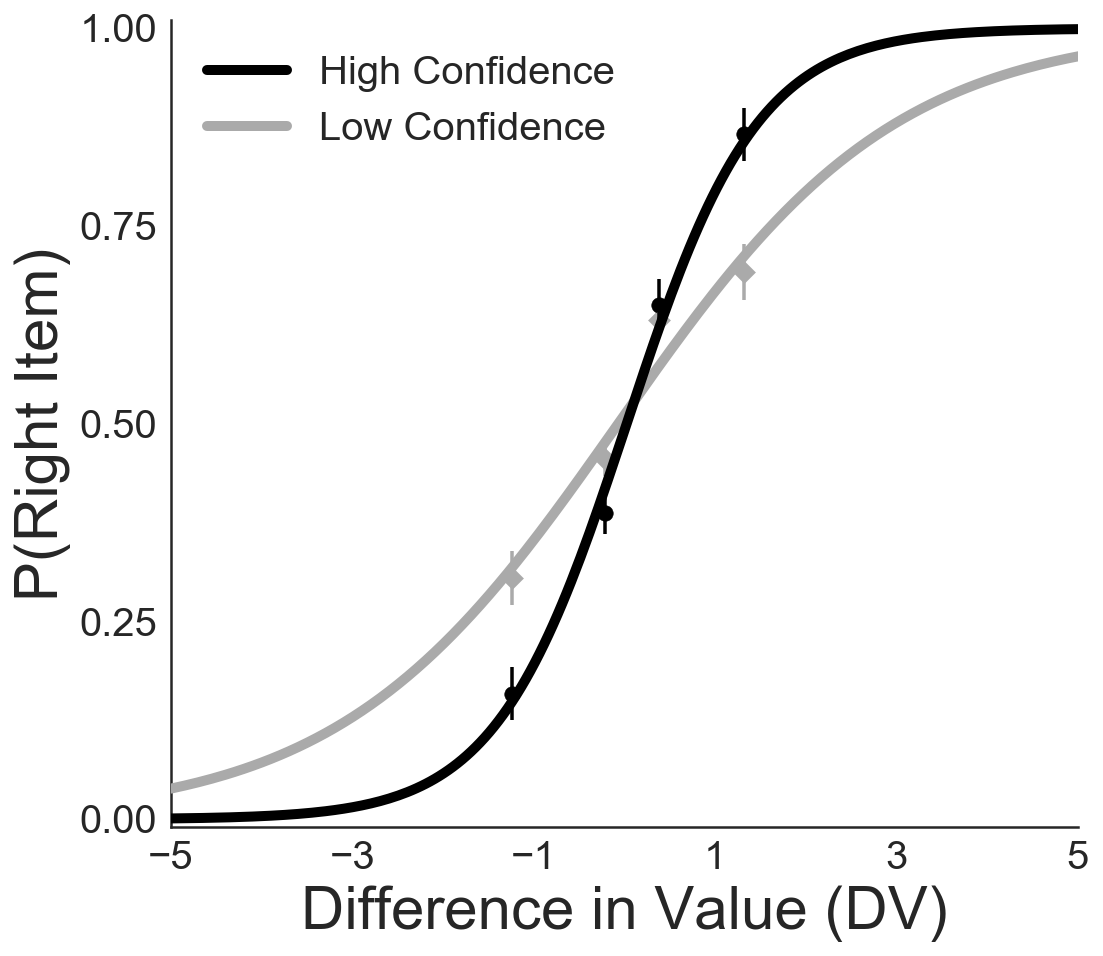

In [59]:
# Split by high/low conf
logisticplot_all('ConfSplit', 'High Confidence', 'Low Confidence', data=data_expL, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

#### TO DO:  Check the slopes 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


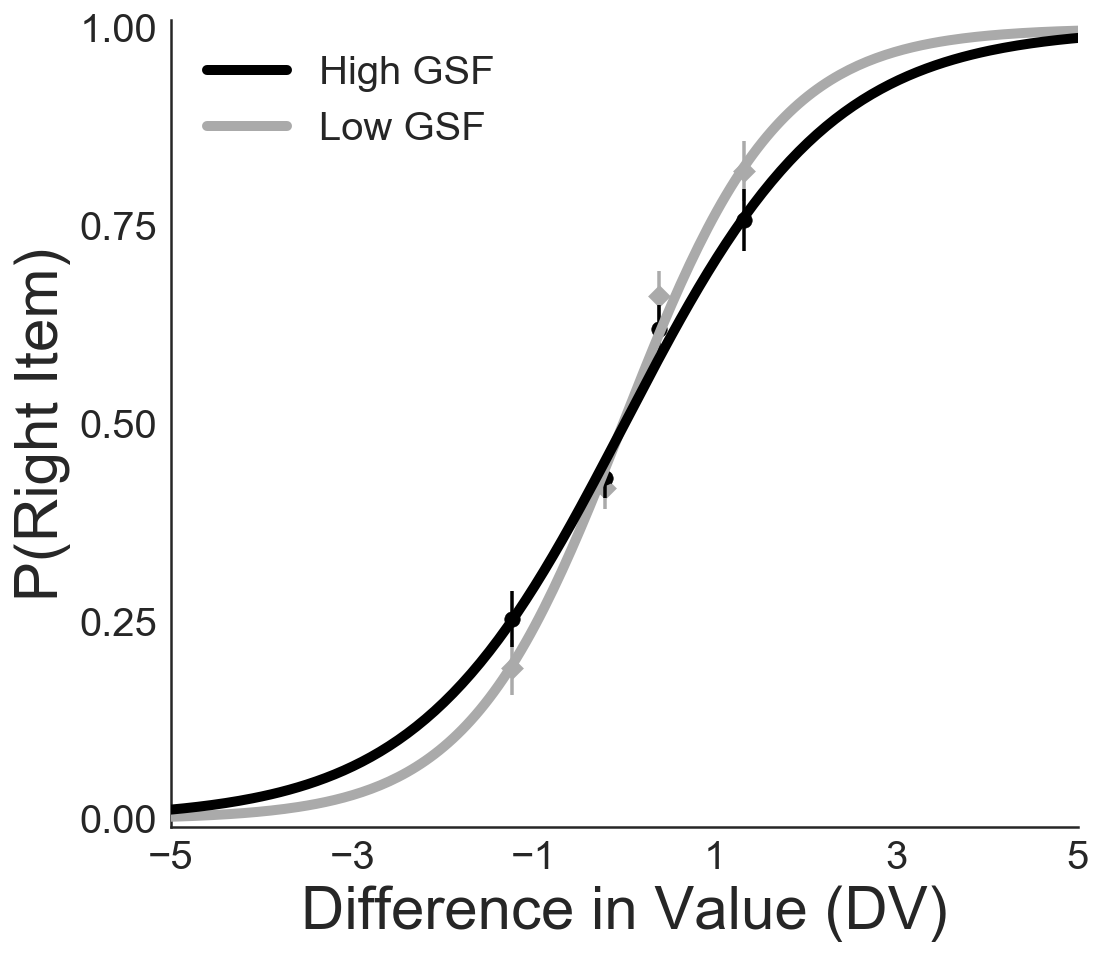

In [60]:
# Split by high/low gaze shift frequency
logisticplot_all('GSFMedSplit', 'High GSF', 'Low GSF', data=data_expL, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


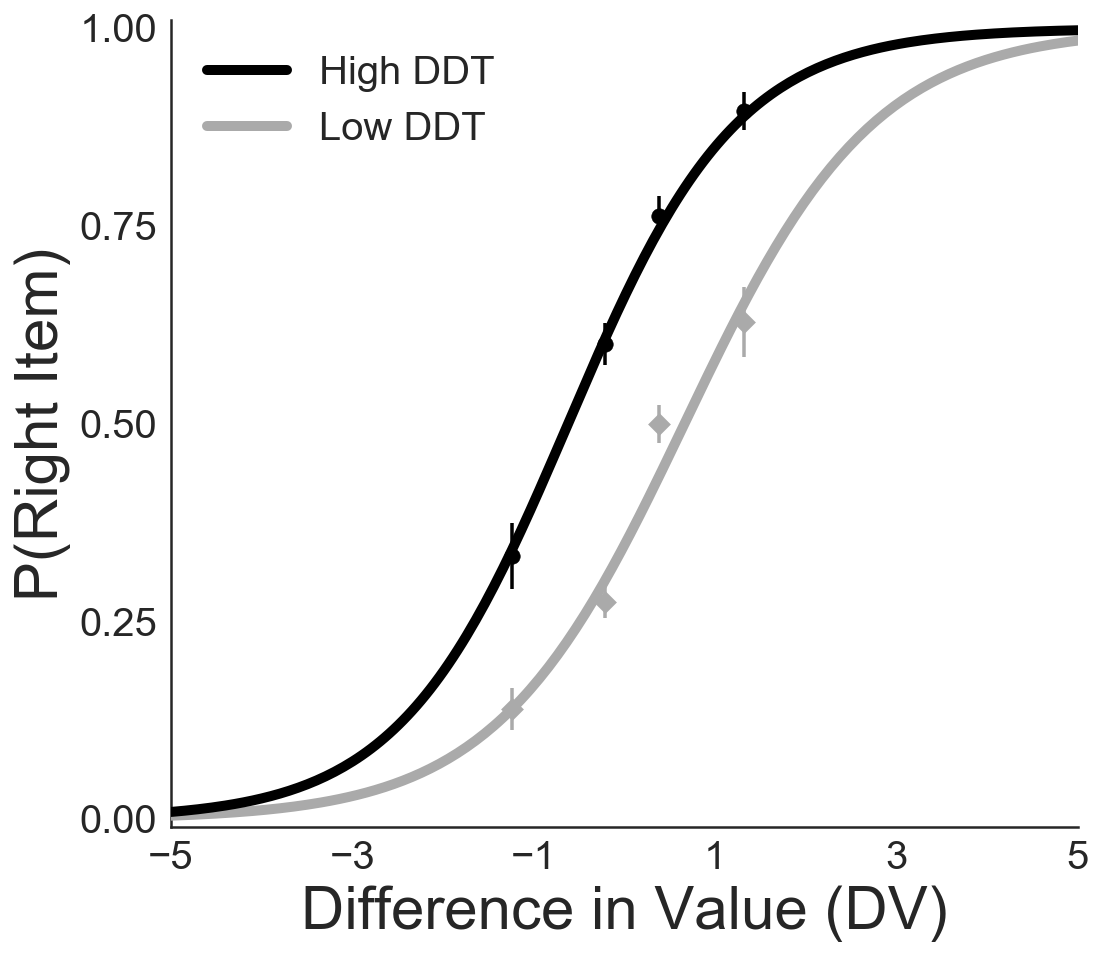

In [61]:
# Split by high/low dwelling time
logisticplot_all('DDTMedSplit', 'High DDT', 'Low DDT', data=data_expL, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

In [62]:
##absolute DDT
#logisticplot_all('absDDTMedSplit', 'High absDDT', 'Low absDDT', data=data_expL
#            , xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
#                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
#plt.tight_layout()

## Dislike Condition

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


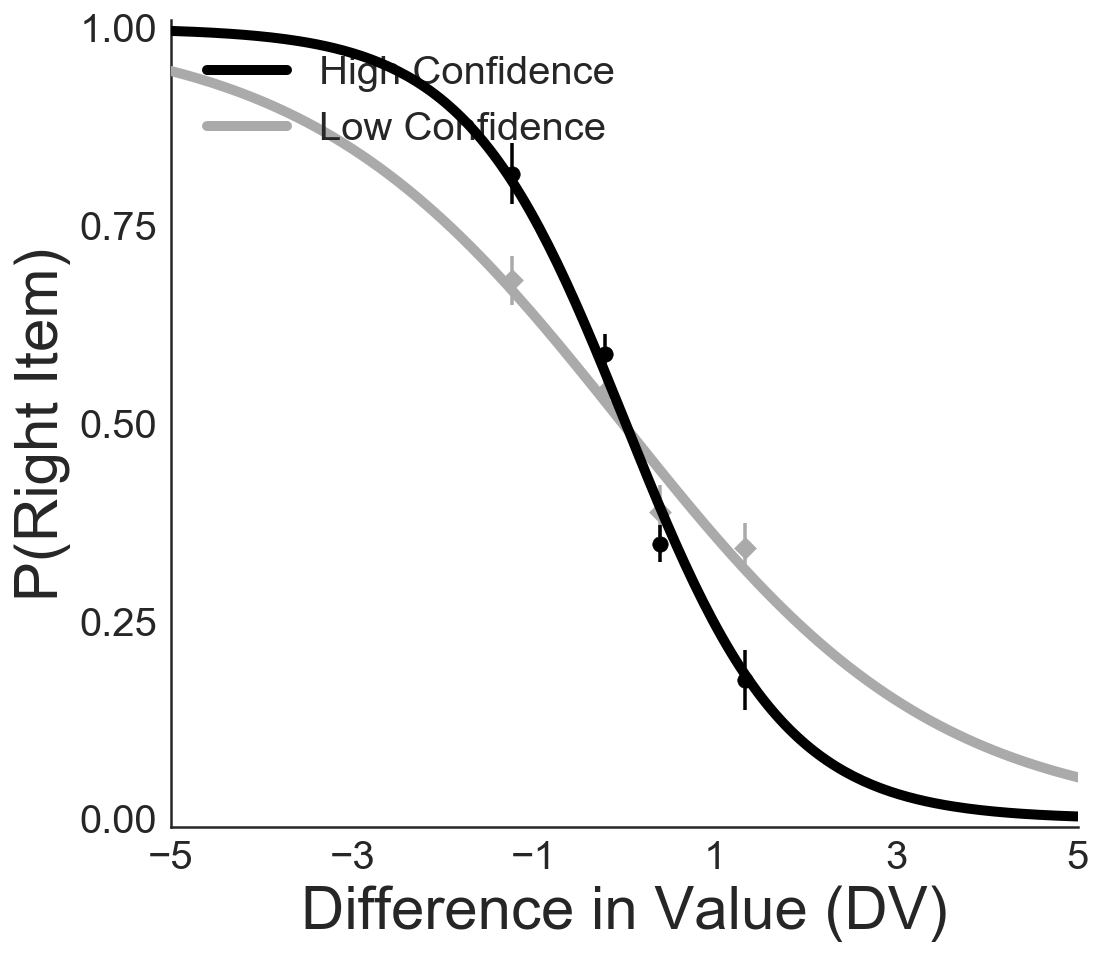

In [63]:
# Split by high/low conf
logisticplot_all('ConfSplit', 'High Confidence', 'Low Confidence', data=data_expD, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


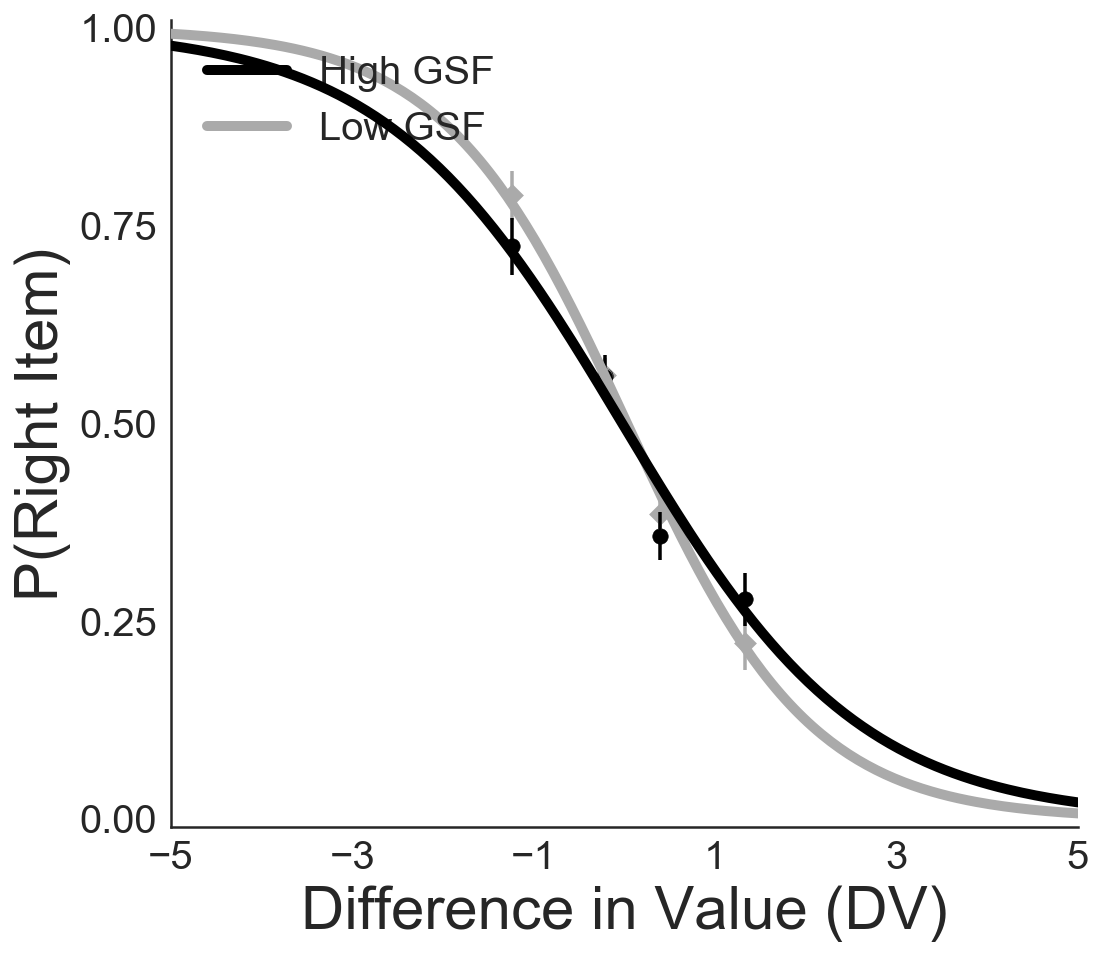

In [64]:
# Split by high/low gaze shift frequency
logisticplot_all('GSFMedSplit', 'High GSF', 'Low GSF', data=data_expD, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


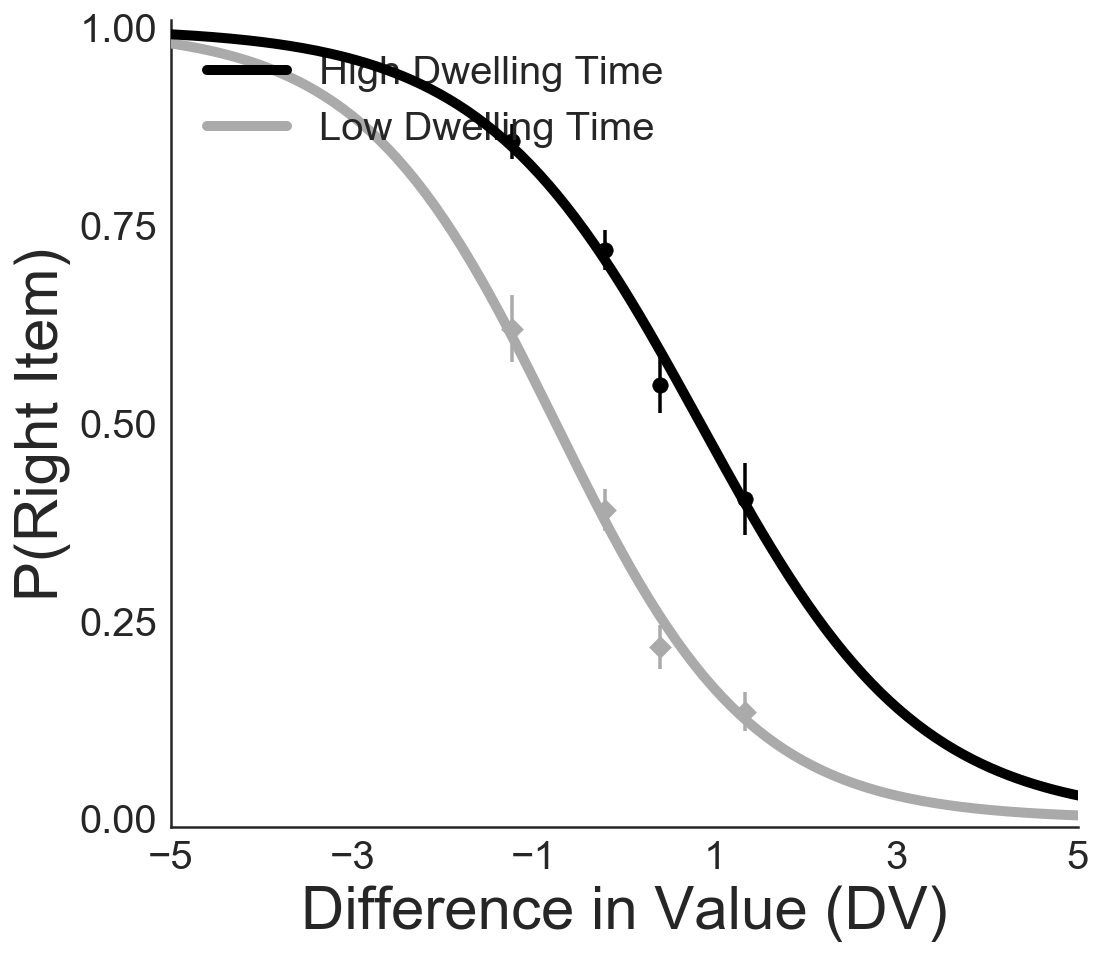

In [65]:
# Split by high/low dwelling time
logisticplot_all('DDTMedSplit', 'High Dwelling Time', 'Low Dwelling Time', data=data_expD, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Difference in Value (DV)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

<a id='reg'></a>
# Regression Analysis

## Loading data in R

In [66]:
%R -i data_exp1
data_exp1

Part  TrialN  PairID                                L_Item  L_Value  \
0        1       1      14                116_boots_caramels.png     0.95   
1        1       2      44          102_propercorn_worcester.png     2.30   
2        1       3      51                       59_crunchie.png     1.70   
3        1       4      12               64_nestle_aero_mint.png     1.55   
4        1       5       4           44_walkers_french_fries.png     2.00   
5        1       6      39       50_nakd_rhubarb_and_custard.png     0.65   
6        1       7      59           54_milkyway_magic_stars.png     1.55   
7        1       8      16                116_boots_caramels.png     0.95   
8        1       9       1                  62_cadbury_wispa.png     1.55   
9        1      10      48           44_walkers_french_fries.png     2.00   
10       1      11      37                13_fruit_pastilles.png     1.10   
11       1      12       6     36_nature_valley_protein_bars.png     1.40   
12       1      13      35         41_jelly_babies_berry_mix.png     1.85   
13       1      14      45                       51_smarties.png     1.70   
14       1      15      58                       5_caramello.png     1.25   
15       1      16      41                   11_lindt_orange.png     2.00   
16       1      17      42                         63_kitkat.png     1.85   
17       1      18      52       42_dairy_milk_fruit_and_nut.png     1.55   
18       1      19      49            52_discos_salt_vinegar.png     1.70   
19       1      20      33                         26_yorkie.png     1.70   
20       1      21       7             30_starburst_original.png     1.10   
21       1      22      38                   56_marshmallows.png     0.95   
22       1      23      47                       51_smarties.png     1.70   
23       1      24      34                     19_pistachios.png     1.70   
24       1      25      15  57_food_doctor_mild_korma_crisps.png     1.25   
25       1      26       5                113_walkers_cheese.png     2.00   
26       1      27      46            112_lindt_extra_creamy.png     1.85   
27       1      28      50                         63_kitkat.png     1.85   
28       1      29      43                    103_nakd_berry.png     1.85   
29       1      30      11                     18_galaxy_bar.png     1.10   
...    ...     ...     ...                                   ...      ...   
9330    39     211      45                   56_marshmallows.png     2.15   
9331    39     212      46                    40_nestle_rolo.png     0.95   
9332    39     213      43           15_jacobs_mini_cheddars.png     2.00   
9333    39     214      16                    48_mentos_mint.png     1.55   
9334    39     215      30                       32_snickers.png     2.00   
9335    39     216      37                    40_nestle_rolo.png     0.95   
9336    39     217      38                      45_gb_ginger.png     0.20   
9337    39     218      49        111_propercorn_sweetnsalty.png     0.65   
9338    39     219      48                    110_bombay_mix.png     0.00   
9339    39     220      31     53_eat_natural_almond_apricot.png     2.45   
9340    39     221      26                     29_mms_peanut.png     3.00   
9341    39     222      40            60_caramel_rice_crisps.png     1.70   
9342    39     223      24                117_yogurt_raisins.png     2.90   
9343    39     224      53                  107_graze_scream.png     0.65   
9344    39     225      41                       39_milkyway.png     2.45   
9345    39     226      20            10_hula_hoops_bbq_beef.png     0.00   
9346    39     227      29             115_shapers_blueberry.png     3.00   
9347    39     228      50           44_walkers_french_fries.png     2.00   
9348    39     229      47                      109_kp_roast.png     2.00   
9349    39     230      14                117_yogurt_raisins.png     2.90   
93

In [67]:
%%R
#Change Column name for better regression presentation
colnames(data_exp1)[which(names(data_exp1) == "zChoiceRT")] <- "zRT"
colnames(data_exp1)[which(names(data_exp1) == "ChoiceRT")] <- "RT"
colnames(data_exp1)[which(names(data_exp1) == "ztDDT")] <- "zDDT"
colnames(data_exp1)[which(names(data_exp1) == "ztGSF")] <- "zGSF"

In [68]:
%%R
# Separating the data for both conditions 
data_exp1_Like <- data_exp1[ which(data_exp1$BlockCond=='1'), ]
data_exp1_DisLike <- data_exp1[ which(data_exp1$BlockCond=='2'), ]

## Comparing groups mean per condition 

[1] "T-test for RT across groups "

	Welch Two Sample t-test

data:  data_exp1_Like[["RT"]] and data_exp1_DisLike[["RT"]]
t = -7.1367, df = 7783.8, p-value = 1.042e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -420.0066 -238.9954
sample estimates:
mean of x mean of y 
 2823.373  3152.874 

[1] "T-test for CONFIDENCE across groups "

	Welch Two Sample t-test

data:  data_exp1_Like[["Conf"]] and data_exp1_DisLike[["Conf"]]
t = 8.3201, df = 7788.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.701523 5.983325
sample estimates:
mean of x mean of y 
 76.81667  71.97424 



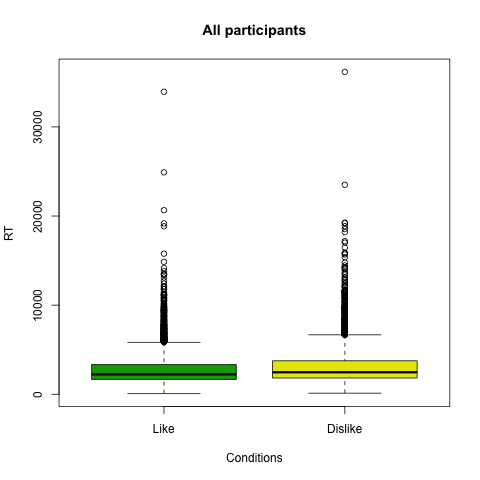

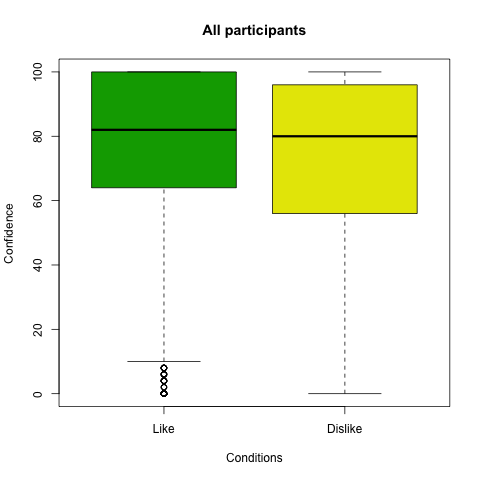

In [69]:
%%R
#Checking that RT and confidence levels are similar across conditions (like-dislike)
MeanLikeRT = mean(data_exp1_Like[["RT"]])
MeanDislikeRT = mean(data_exp1_DisLike[["RT"]])

MeanLikeConf = mean(data_exp1_Like[["Conf"]])
MeanDislikeConf = mean(data_exp1_DisLike[["Conf"]])

p_rt = t.test(data_exp1_Like[["RT"]],data_exp1_DisLike[["RT"]])
p_conf = t.test(data_exp1_Like[["Conf"]],data_exp1_DisLike[["Conf"]])

#Generate boxpot for Reaction time per condition
boxplot(data_exp1$RT ~ data_exp1$BlockCond , col=terrain.colors(4), names=c("Like","Dislike"))
title(main="All participants", 
   xlab="Conditions", ylab="RT")

#Generate boxpot for Confidence per condition
boxplot(data_exp1$Conf ~ data_exp1$BlockCond , col=terrain.colors(4), names=c("Like","Dislike"))
title(main="All participants", 
   xlab="Conditions", ylab="Confidence")

## Add data points
#mylevels<-levels(data_exp1$BlockCond)
#levelProportions<-summary(data_exp1$BlockCond)/nrow(data_exp1)
#for(i in 1:length(mylevels)){
#  thislevel<-mylevels[i]
#  thisvalues<-data_exp1[data_exp1$BlockCond==thislevel, "RT"]

#   # take the x-axis indices and add a jitter, proportional to the N in each level
#  myjitter<-jitter(rep(i, length(thisvalues)), amount=levelProportions[i]/2)
#  points(myjitter, thisvalues, pch=20, col=rgb(0,0,0,.2))  
#}

print("T-test for RT across groups ")
print(p_rt)

print("T-test for CONFIDENCE across groups ")
print( p_conf)

## Regressions per Condition (Like/Dislike)
### ChoiceITM~ BehavioralParams + DDT

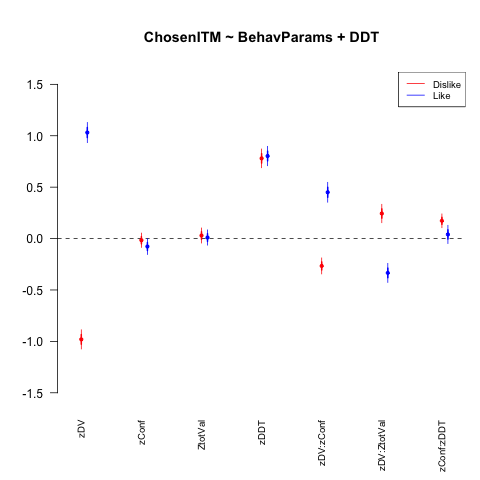

In [70]:
%%R
# Figure replicating Folke 2016.

logitModLike_FF2017 <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_exp1_Like, family=binomial(link="logit"))
logitModDislike_FF2017 <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_exp1_DisLike, family=binomial(link="logit"))

coefplot(logitModDislike_FF2017,intercept=FALSE,vertical = FALSE,  col.pts="red", mar = c(3,4,5,1) ,ylim=c(-1.5, 1.5) ,main="ChosenITM ~ BehavParams + DDT")
coefplot(logitModLike_FF2017, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1))
legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=0.8)

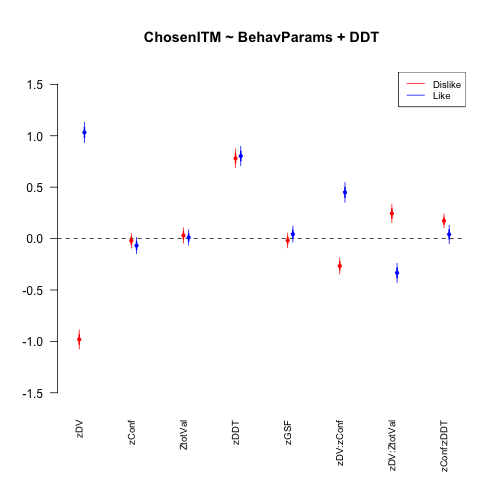

In [71]:
%%R
# Figure replicating Folke 2016.

logitModLike_FF2017 <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zGSF + zConf:zDDT, data=data_exp1_Like, family=binomial(link="logit"))
logitModDislike_FF2017 <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zGSF + zConf:zDDT, data=data_exp1_DisLike, family=binomial(link="logit"))

coefplot(logitModDislike_FF2017,intercept=FALSE,vertical = FALSE,  col.pts="red", mar = c(3,4,5,1) ,ylim=c(-1.5, 1.5) ,main="ChosenITM ~ BehavParams + DDT")
coefplot(logitModLike_FF2017, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1))
legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=0.8)

### Confidence ~ BehavParams + GSF

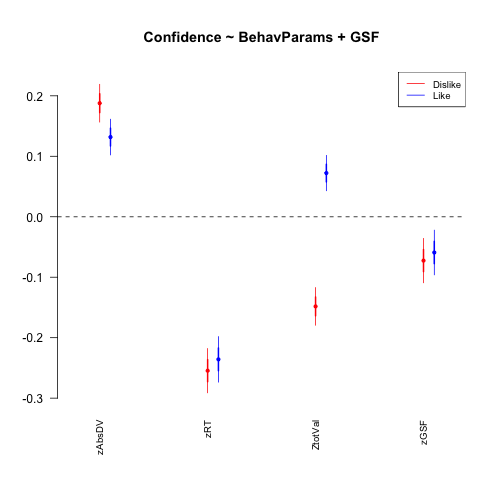

In [72]:
%%R
# Figure replicating Folke 2016. 

logitModLike_FF2017 <- glm(zConf ~ zAbsDV + zRT  + ZtotVal + zGSF , data=data_exp1_Like)
logitModDislike_FF2017 <- glm(zConf ~ zAbsDV + zRT + ZtotVal + zGSF , data=data_exp1_DisLike)

#summary(logitMod_FF2017)
#summary(logitModLike_FF2017)
#summary(logitModUnlike_FF2017)

coefplot(logitModDislike_FF2017,intercept=FALSE, vertical = FALSE, col.pts="red", offset = 0.05, mar = c(3,4,5,1) ,main="Confidence ~ BehavParams + GSF")
coefplot(logitModLike_FF2017, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1),main="RegEstim")
legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=0.8)

# Generate regression plots for condition and individual participants 
## ChoiceITM~ BehavioralParams + DDT

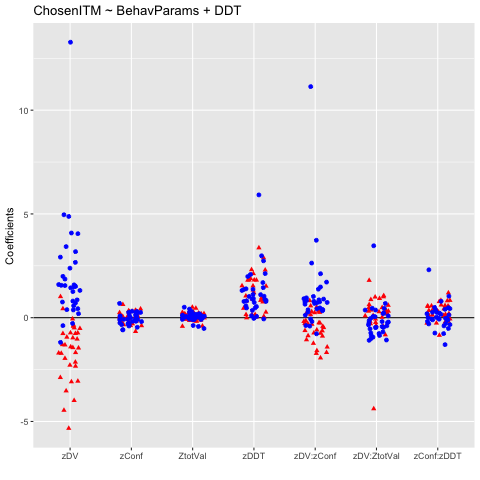

In [73]:
%%R
#Generate regression plots for individual participants 
#ChoiceITM~ BehavioralParams + DDT

#Run for all the participants

# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 7)
for (i in unique(data_exp1_Like[,"Part"])){
data_rgrs_subj  <- data_exp1_Like[ which(data_exp1_Like$Part==i), ]
rsults <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:8])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameLike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length(a)){
colnames(CoefsDataFrameLike)[j-1] <- a[j]
}
CoefsDataFrameLike

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 7)
for (i in unique(data_exp1_DisLike[,"Part"])){
data_rgrs_subj  <- data_exp1_DisLike[ which(data_exp1_DisLike$Part==i), ]
rsults <- glm(ChosenITM ~ zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:8])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameDislike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameDislike)[j-1] <- a[j]
}
CoefsDataFrameDislike

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameDislike),aes(x=variable, y=value), shape = 17, color='red', position = jitter) +
      geom_point(data = melt(CoefsDataFrameLike), aes(x=variable, y=value),color='blue', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("ChosenITM ~ BehavParams + DDT") + theme(legend.position="Top") 

#save as an image
ggsave("Output/Choice_Reg_Participant.tiff", units="in", width=6, height=4, dpi=300, compression = 'lzw')
plot2

### Different colors by participant

In [74]:
#%%R
#### CoefsDataFrameLike <- melt(CoefsDataFrameLike)
#### CoefsDataFrameDislike <- melt(CoefsDataFrameDislike)
#### 
#### CoefsDataFrameLike$participant      <- as.character(rep(unique(data_exp1_Like[,"Part"]), length (a)-1))
#### CoefsDataFrameDislike$participant<- as.character(rep(unique(data_exp1_DisLike[,"Part"]), length (a)-1))
#### 
#### jitter <- position_jitter(width = 0.25)
#### plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
####       geom_point(data = CoefsDataFrameDislike,aes(x=variable, y=value, colour =participant ), shape = 7,size = 3, position = jitter,show.legend = TRUE) +
####       geom_point(data = CoefsDataFrameLike, aes(x=variable, y=value, colour = participant), shape = 10, position = jitter,size = 3,,show.legend = TRUE)  +
####       labs(x = "", y = "Coefficients") + 
####       ggtitle("ChosenITM ~ BehavParams + DDT")+
####       theme_bw()
#### #save as an image
#### ggsave("Output/Choice_Reg_ParticipantColors.tiff", units="in", width=8, height=4, dpi=300, compression = 'lzw')
#### 
#### plot2

## Confidence ~ BehavParams + GSF

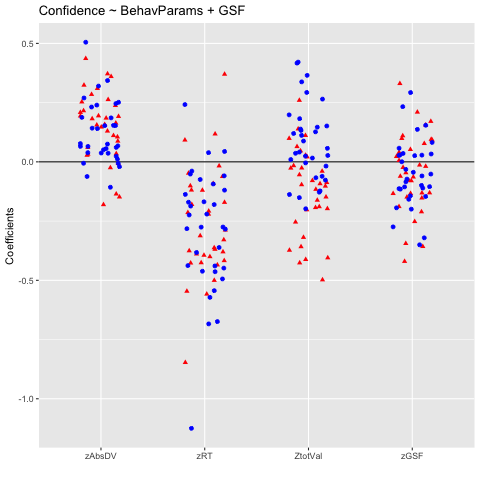

In [75]:
%%R

#Generate regression plots for individual participants 
# Confidence ~ BehavParams + GSF

#Run for all the participants

# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 4)
for (i in unique(data_exp1_Like[,"Part"])){
data_rgrs_subj  <- data_exp1_Like[ which(data_exp1_Like$Part==i), ]
rsults <- glm(zConf ~ zAbsDV + zRT  + ZtotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:5])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameLike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameLike)[j-1] <- a[j]
}
CoefsDataFrameLike

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 4)
for (i in unique(data_exp1_DisLike[,"Part"])){
data_rgrs_subj  <- data_exp1_DisLike[ which(data_exp1_DisLike$Part==i), ]
rsults <- glm(zConf ~ zAbsDV + zRT  + ZtotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:5])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameDislike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameDislike)[j-1] <- a[j]
}
CoefsDataFrameDislike

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameDislike),aes(x=variable, y=value), shape = 17, color='red', position = jitter) +
      geom_point(data = melt(CoefsDataFrameLike), aes(x=variable, y=value),color='blue', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Confidence ~ BehavParams + GSF") + theme(legend.position="Top") 
      
ggsave("Output/Confidence_Reg_Participant.tiff", units="in", width=5, height=4, dpi=300, compression = 'lzw')

plot2


### Different colors by participant

In [76]:
%%R
#### CoefsDataFrameLike <- melt(CoefsDataFrameLike)
#### CoefsDataFrameDislike <- melt(CoefsDataFrameDislike)
#### 
#### CoefsDataFrameLike$participant      <- as.character(rep(unique(data_exp1_Like[,"Part"]), length (a)-1))
#### CoefsDataFrameDislike$participant<- as.character(rep(unique(data_exp1_DisLike[,"Part"]), length (a)-1))
#### 
#### jitter <- position_jitter(width = 0.25)
#### plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
####       geom_point(data = CoefsDataFrameDislike,aes(x=variable, y=value, colour =participant ), shape = 7,size = 5, position = jitter,show.legend = TRUE) +
####       geom_point(data = CoefsDataFrameLike, aes(x=variable, y=value, colour = participant), shape = 10, position = jitter,size = 5,,show.legend = TRUE)  +
####       labs(x = "", y = "Coefficients") + 
####       ggtitle("Confidence ~ BehavParams + GSF")+
####       theme_bw()
####  
#### ggsave("Output/Confidence_Reg_ParticipantColors.tiff", units="in", width=5, height=4, dpi=300, compression = 'lzw')
#### 
#### plot2

NULL


# Hierarchical Regression

## Choice ~ BehavioralParams + DDT

### Dislike condition model

In [313]:
%%R
# Fit binomial hierarchical model
Choice_Dislike_hmodel =  glmer(ChosenITM ~ -1 + zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT + (zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT | Part), data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (Choice_Dislike_hmodel)

glmer(formula = ChosenITM ~ -1 + zDV + zConf + ZtotVal + zDV:zConf + 
    zDV:ZtotVal + zDDT + zConf:zDDT + (zDV + zConf + ZtotVal + 
    zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT | Part), data = data_exp1_DisLike, 
    family = "binomial", control = glmerControl(optimizer = "optimx", 
        optCtrl = list(method = "nlminb")))
            coef.est coef.se
zDV         -1.36     0.18  
zConf        0.01     0.04  
ZtotVal      0.05     0.04  
zDDT         0.98     0.13  
zDV:zConf   -0.43     0.10  
zDV:ZtotVal  0.24     0.07  
zConf:zDDT   0.25     0.05  

Error terms:
 Groups   Name        Std.Dev. Corr                                      
 Part     (Intercept) 0.04                                               
          zDV         0.96      0.64                                     
          zConf       0.09     -0.25 -0.76                               
          ZtotVal     0.02      0.75  0.63 -0.69                         
          zDDT        0.64      0.71 -0.01  0.43  0

In [314]:
%%R

#Extract parameters
fix_Choice_Dislike_hmodel <- fixef(Choice_Dislike_hmodel)
fix_se_Choice_Dislike_hmodel <- sqrt(diag(vcov(Choice_Dislike_hmodel)))
names_Choice_Dislike_hmodel <- names(fix_Choice_Dislike_hmodel)
summary(Choice_Dislike_hmodel)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: ChosenITM ~ -1 + zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal +  
    zDDT + zConf:zDDT + (zDV + zConf + ZtotVal + zDV:zConf +  
    zDV:ZtotVal + zDDT + zConf:zDDT | Part)
   Data: data_exp1_DisLike
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  4111.9   4382.1  -2012.9   4025.9     3917 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4654 -0.6625  0.0029  0.6854 12.9973 

Random effects:
 Groups Name        Variance  Std.Dev. Corr                               
 Part   (Intercept) 0.0012275 0.03504                                     
        zDV         0.9289976 0.96385   0.64                              
        zConf       0.0083631 0.09145  -0.25 -0.76                        
        ZtotVal     0.0002464 0.01570   0.75  0.63 -0.69                  

In [316]:
%R -o fix_Choice_Dislike_hmodel -o fix_se_Choice_Dislike_hmodel -o names_Choice_Dislike_hmodel

#Generate table with parameters to plot
Choice_Dislike_hmodel_table = regtable(fix_Choice_Dislike_hmodel, fix_se_Choice_Dislike_hmodel, names_Choice_Dislike_hmodel)
Choice_Dislike_hmodel_table.columns = [ '|DV|', 'Confidence', "TotValue", "DDT", "DV x Conf", " DV x TotValue", "Conf x DDT"]
#Coefpresplot(Choice_Dislike_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')

### Like Condition

In [317]:
%%R
# Fit binomial hierarchical model
Choice_Like_hmodel =  glmer(ChosenITM ~ -1 + zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT + (zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT | Part), data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (Choice_Like_hmodel)

glmer(formula = ChosenITM ~ -1 + zDV + zConf + ZtotVal + zDV:zConf + 
    zDV:ZtotVal + zDDT + zConf:zDDT + (zDV + zConf + ZtotVal + 
    zDV:zConf + zDV:ZtotVal + zDDT + zConf:zDDT | Part), data = data_exp1_Like, 
    family = "binomial", control = glmerControl(optimizer = "optimx", 
        optCtrl = list(method = "nlminb")))
            coef.est coef.se
zDV          1.54     0.23  
zConf       -0.07     0.05  
ZtotVal      0.01     0.04  
zDDT         0.89     0.10  
zDV:zConf    0.67     0.11  
zDV:ZtotVal -0.39     0.08  
zConf:zDDT   0.04     0.06  

Error terms:
 Groups   Name        Std.Dev. Corr                                      
 Part     (Intercept) 0.10                                               
          zDV         1.20     -0.15                                     
          zConf       0.05     -0.78 -0.51                               
          ZtotVal     0.04     -0.85  0.42  0.47                         
          zDDT        0.51      0.71  0.00 -0.62 -0.88

In [323]:
%%R
#Extract regression parameters
fix_Choice_Like_hmodel <- fixef(Choice_Like_hmodel)
fix_se_Choice_Like_hmodel <- sqrt(diag(vcov(Choice_Like_hmodel)))
names_Choice_Like_hmodel <- names(Choice_Like_hmodel)
summary(Choice_Like_hmodel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: ChosenITM ~ -1 + zDV + zConf + ZtotVal + zDV:zConf + zDV:ZtotVal +  
    zDDT + zConf:zDDT + (zDV + zConf + ZtotVal + zDV:zConf +  
    zDV:ZtotVal + zDDT + zConf:zDDT | Part)
   Data: data_exp1_Like
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  3918.0   4188.3  -1916.0   3832.0     3917 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3283 -0.6088  0.0014  0.6439 10.7247 

Random effects:
 Groups Name        Variance Std.Dev. Corr                                     
 Part   (Intercept) 0.009206 0.09595                                           
        zDV         1.432513 1.19688  -0.15                                    
        zConf       0.002824 0.05315  -0.78 -0.51                              
        ZtotVal     0.001314 0.03625  -0.85  0.42  0.47  

In [341]:
Choice_Like_hmodel_table

|DV|  Confidence  TotValue       DDT  DV x Conf  \
coefficient  1.538266   -0.072405  0.014571  0.887955   0.666304   
se           0.228560    0.045330  0.041101  0.104993   0.111401   
CImin        1.090288   -0.161251 -0.065986  0.682167   0.447958   
CImax        1.986244    0.016441  0.095128  1.093742   0.884651   

              DV x TotValue  Conf x DDT  
coefficient       -0.386817    0.038762  
se                 0.080253    0.063675  
CImin             -0.544113   -0.086041  
CImax             -0.229522    0.163564

In [319]:
%R -o fix_Choice_Like_hmodel -o fix_se_Choice_Like_hmodel #-o names_Choice_Like_hmodel

# we use the same names that were defined for the predictors that in the dislike case, since they are the same in both cases
Choice_Like_hmodel_table = regtable(fix_Choice_Like_hmodel, fix_se_Choice_Like_hmodel, names_Choice_Dislike_hmodel)
Choice_Like_hmodel_table.columns = [ '|DV|', 'Confidence', "TotValue", "DDT", "DV x Conf", " DV x TotValue", "Conf x DDT"]
#Coefpresplot(Choice_Like_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')


### Plotting both conditions

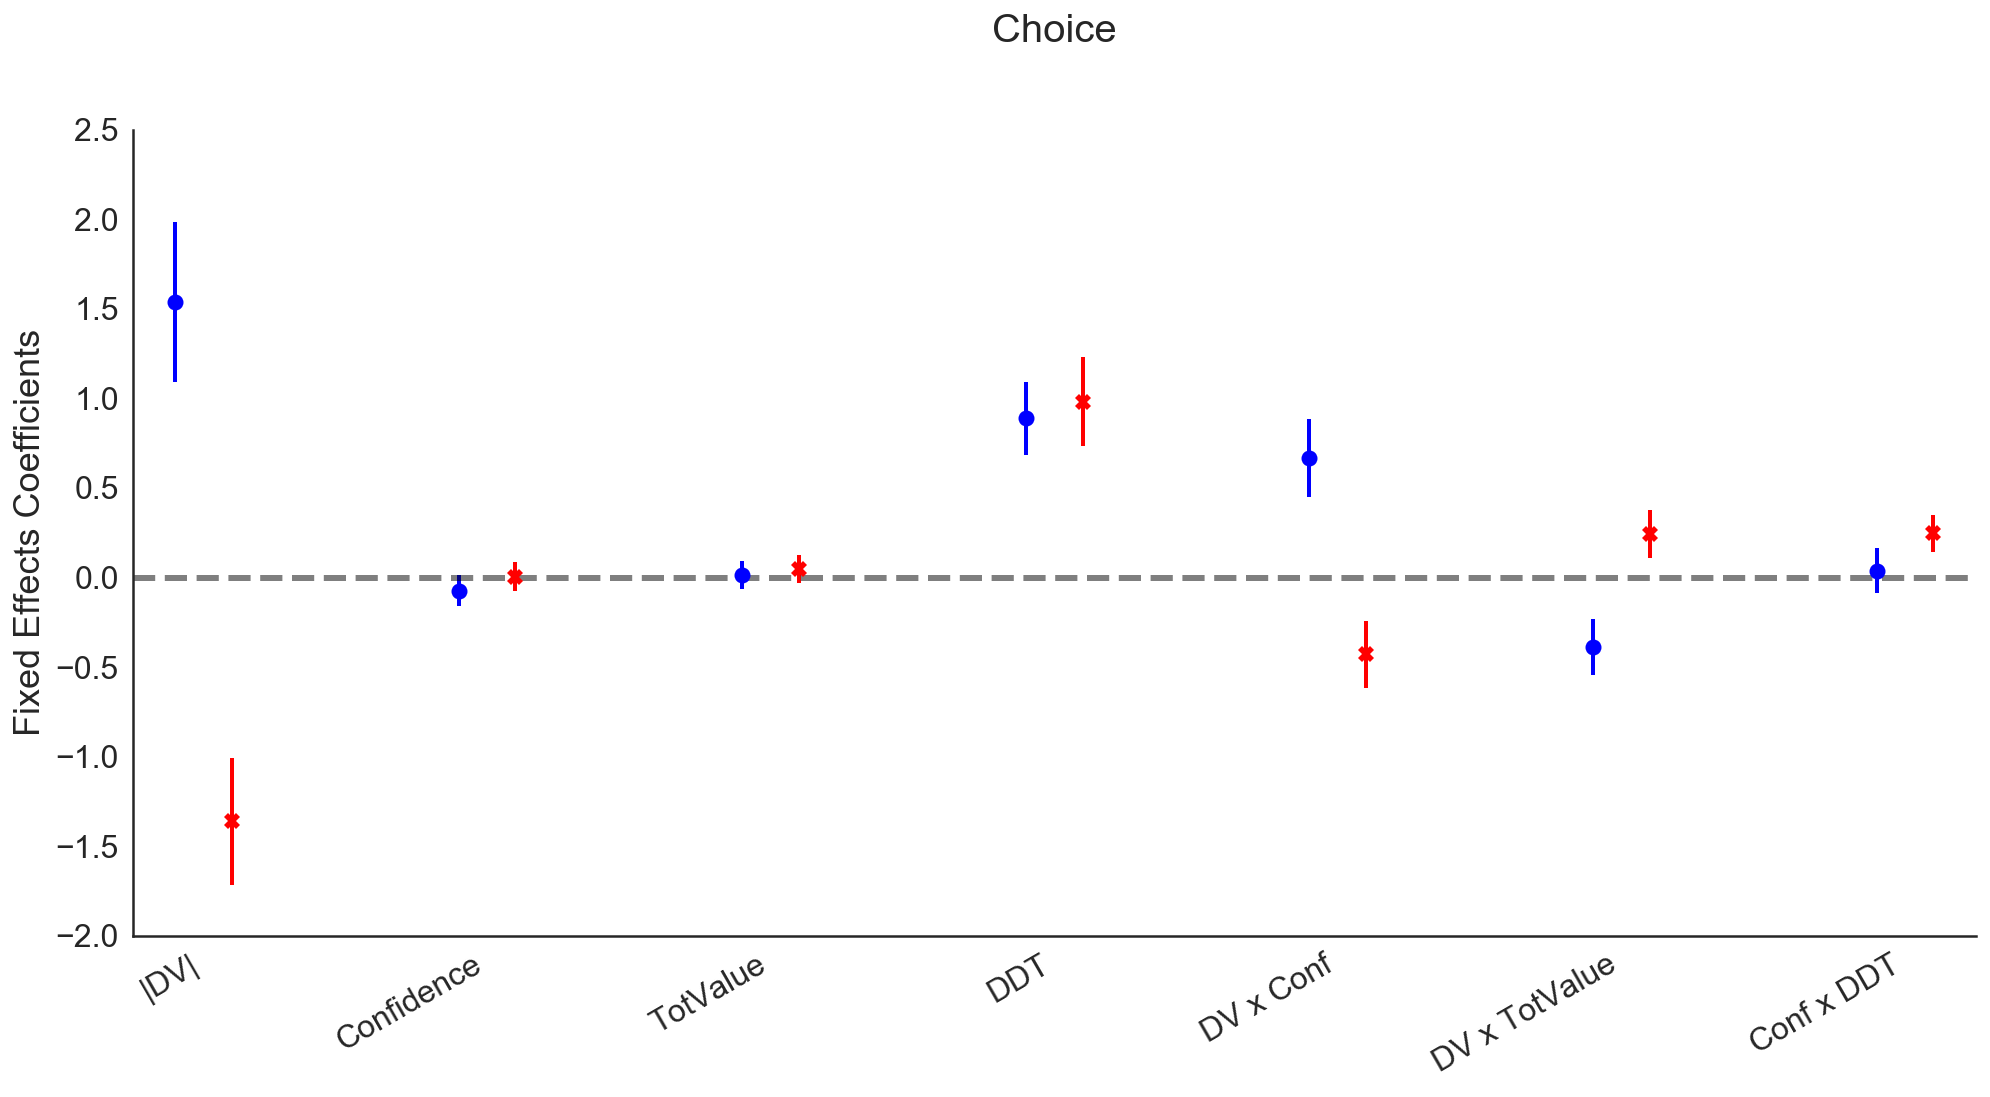

In [339]:
Coefpresplot2(Choice_Like_hmodel_table,Choice_Dislike_hmodel_table, title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0)

## Confidence ~ BehavioralParams + GSF

### Dislike condition model

In [251]:
%%R
# Fit the multilevel linear model
confidence_Dislike_hmodel <- lmer(zConf ~ -1 + zRT + zAbsDV + ZtotVal + zGSF + ( zRT + zAbsDV + ZtotVal + zGSF| Part), data=data_exp1_DisLike, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (confidence_Dislike_hmodel)

lmer(formula = zConf ~ -1 + zRT + zAbsDV + ZtotVal + zGSF + (zRT + 
    zAbsDV + ZtotVal + zGSF | Part), data = data_exp1_DisLike, 
    control = lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb")))
        coef.est coef.se
zRT     -0.27     0.03  
zAbsDV   0.15     0.02  
ZtotVal -0.08     0.03  
zGSF    -0.05     0.03  

Error terms:
 Groups   Name        Std.Dev. Corr                    
 Part     (Intercept) 0.12                             
          zRT         0.16     -0.06                   
          zAbsDV      0.11     -0.20 -0.48             
          ZtotVal     0.17      0.66 -0.36 -0.34       
          zGSF        0.13      0.04 -0.04 -0.25  0.40 
 Residual             0.91                             
---
number of obs: 3960, groups: Part, 33
AIC = 10696, DIC = 10612.9
deviance = 10634.5 


In [252]:
%%R

## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Dislike_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Dislike_hmodel, fixef(confidence_Dislike_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))

In [330]:
%%R 
coef(confidence_Dislike_hmodel)

$Part
     (Intercept)         zRT      zAbsDV     ZtotVal         zGSF
1  -0.0987580861 -0.30606283  0.17840872 -0.15835776 -0.126664534
2  -0.0124992067 -0.24067845  0.17897719 -0.10377297  0.002890775
3  -0.0147700028 -0.43816710  0.24578308  0.05195365  0.092776369
4   0.0325665223 -0.40607099  0.21596686 -0.11138693 -0.127396311
5   0.1047201662 -0.40176878  0.19448719 -0.01008820 -0.131907982
8  -0.0239737132 -0.23730792  0.14122113 -0.10463819 -0.025482273
9  -0.0090134287 -0.36221122  0.16401955 -0.04507874 -0.007756760
10 -0.1323943984 -0.23199882  0.20211451 -0.32665722 -0.113256936
11 -0.0371345825 -0.45735171  0.12040287  0.01420941 -0.091751702
12 -0.1771027072 -0.56104810  0.24473328 -0.09485421 -0.161947428
13 -0.1695262078 -0.23172066  0.16850686 -0.30429004  0.051598131
14 -0.2016443108 -0.33060067  0.25296692 -0.30480034 -0.031751665
15 -0.0452067887  0.03326014 -0.04230536 -0.11442987  0.083834342
16 -0.2462740955 -0.18248318  0.18599097 -0.40272336 -0.189659121
18 -

In [253]:
%R -o coefs
conf_table_exp1 = coefs
conf_table_exp1

#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't', 'DF','CImax', 'CImin', 'p', 'p2' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()
conf_table_exp1.columns = [ 'RT','|DV|', 'TotValue','GSF']
conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[['RT','|DV|', 'TotValue','GSF']]
conf_table_Dislike = conf_table_exp1
conf_table_Dislike

RT       |DV|   TotValue        GSF
coefficient  -0.273079   0.147048  -0.083276  -0.045888
se            0.033993   0.024587   0.029100   0.028659
t            -8.033382   5.980745  -2.861699  -1.601163
DF           31.796758  31.796758  31.796758  31.796758
CImax        -0.239086   0.171635  -0.054176  -0.017229
CImin        -0.307072   0.122461  -0.112376  -0.074547
p             0.000000   0.000000   0.007400   0.119200
SEmax        -0.205093   0.196222  -0.025076   0.011430
SEmin        -0.341065   0.097874  -0.141476  -0.103205

### Like Condition

In [254]:
%%R
# Fit the multilevel linear model
confidence_Like_hmodel <- lmer(zConf ~ -1 + zRT + zAbsDV + ZtotVal + zGSF + ( zRT + zAbsDV + ZtotVal + zGSF| Part), data=data_exp1_Like, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (confidence_Like_hmodel)

lmer(formula = zConf ~ -1 + zRT + zAbsDV + ZtotVal + zGSF + (zRT + 
    zAbsDV + ZtotVal + zGSF | Part), data = data_exp1_Like, control = lmerControl(optimizer = "optimx", 
    optCtrl = list(method = "nlminb")))
        coef.est coef.se
zRT     -0.32     0.04  
zAbsDV   0.11     0.02  
ZtotVal  0.12     0.02  
zGSF    -0.04     0.02  

Error terms:
 Groups   Name        Std.Dev. Corr                    
 Part     (Intercept) 0.12                             
          zRT         0.20      0.57                   
          zAbsDV      0.09      0.27  0.12             
          ZtotVal     0.15     -0.76 -0.09  0.20       
          zGSF        0.09     -0.16  0.07 -0.47 -0.02 
 Residual             0.86                             
---
number of obs: 3960, groups: Part, 33
AIC = 10233.6, DIC = 10149.4
deviance = 10171.5 


In [255]:
%%R
## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Like_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Like_hmodel, fixef(confidence_Like_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))

In [256]:
%%R
coefs

          Estimate Std..Error   t.value    df.KR       semax       semin
zRT     -0.3161321 0.03612792 -8.750354 31.65427 -0.28000419 -0.35226003
zAbsDV   0.1129966 0.02125119  5.317188 31.65427  0.13424775  0.09174537
ZtotVal  0.1167632 0.02454477  4.757153 31.65427  0.14130797  0.09221844
zGSF    -0.0447007 0.02380442 -1.877832 31.65427 -0.02089628 -0.06850511
                p.KR          p.z
zRT     5.865903e-10 0.000000e+00
zAbsDV  8.144419e-06 1.053834e-07
ZtotVal 4.114252e-05 1.963424e-06
zGSF    6.964408e-02 6.040411e-02


In [257]:
%R -o coefs
conf_table_exp1 = coefs
conf_table_exp1

#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't', 'DF','CImax', 'CImin', 'p', 'p2' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()
conf_table_exp1.columns = [ 'RT','|DV|', 'TotValue','GSF']
conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[['RT','|DV|', 'TotValue','GSF']]
conf_table_Like = conf_table_exp1
conf_table_Like

RT       |DV|   TotValue        GSF
coefficient  -0.316132   0.112997   0.116763  -0.044701
se            0.036128   0.021251   0.024545   0.023804
t            -8.750354   5.317188   4.757153  -1.877832
DF           31.654274  31.654274  31.654274  31.654274
CImax        -0.280004   0.134248   0.141308  -0.020896
CImin        -0.352260   0.091745   0.092218  -0.068505
p             0.000000   0.000000   0.000000   0.069600
SEmax        -0.243876   0.155499   0.165853   0.002908
SEmin        -0.388388   0.070494   0.067674  -0.092310

### Plotting both conditions

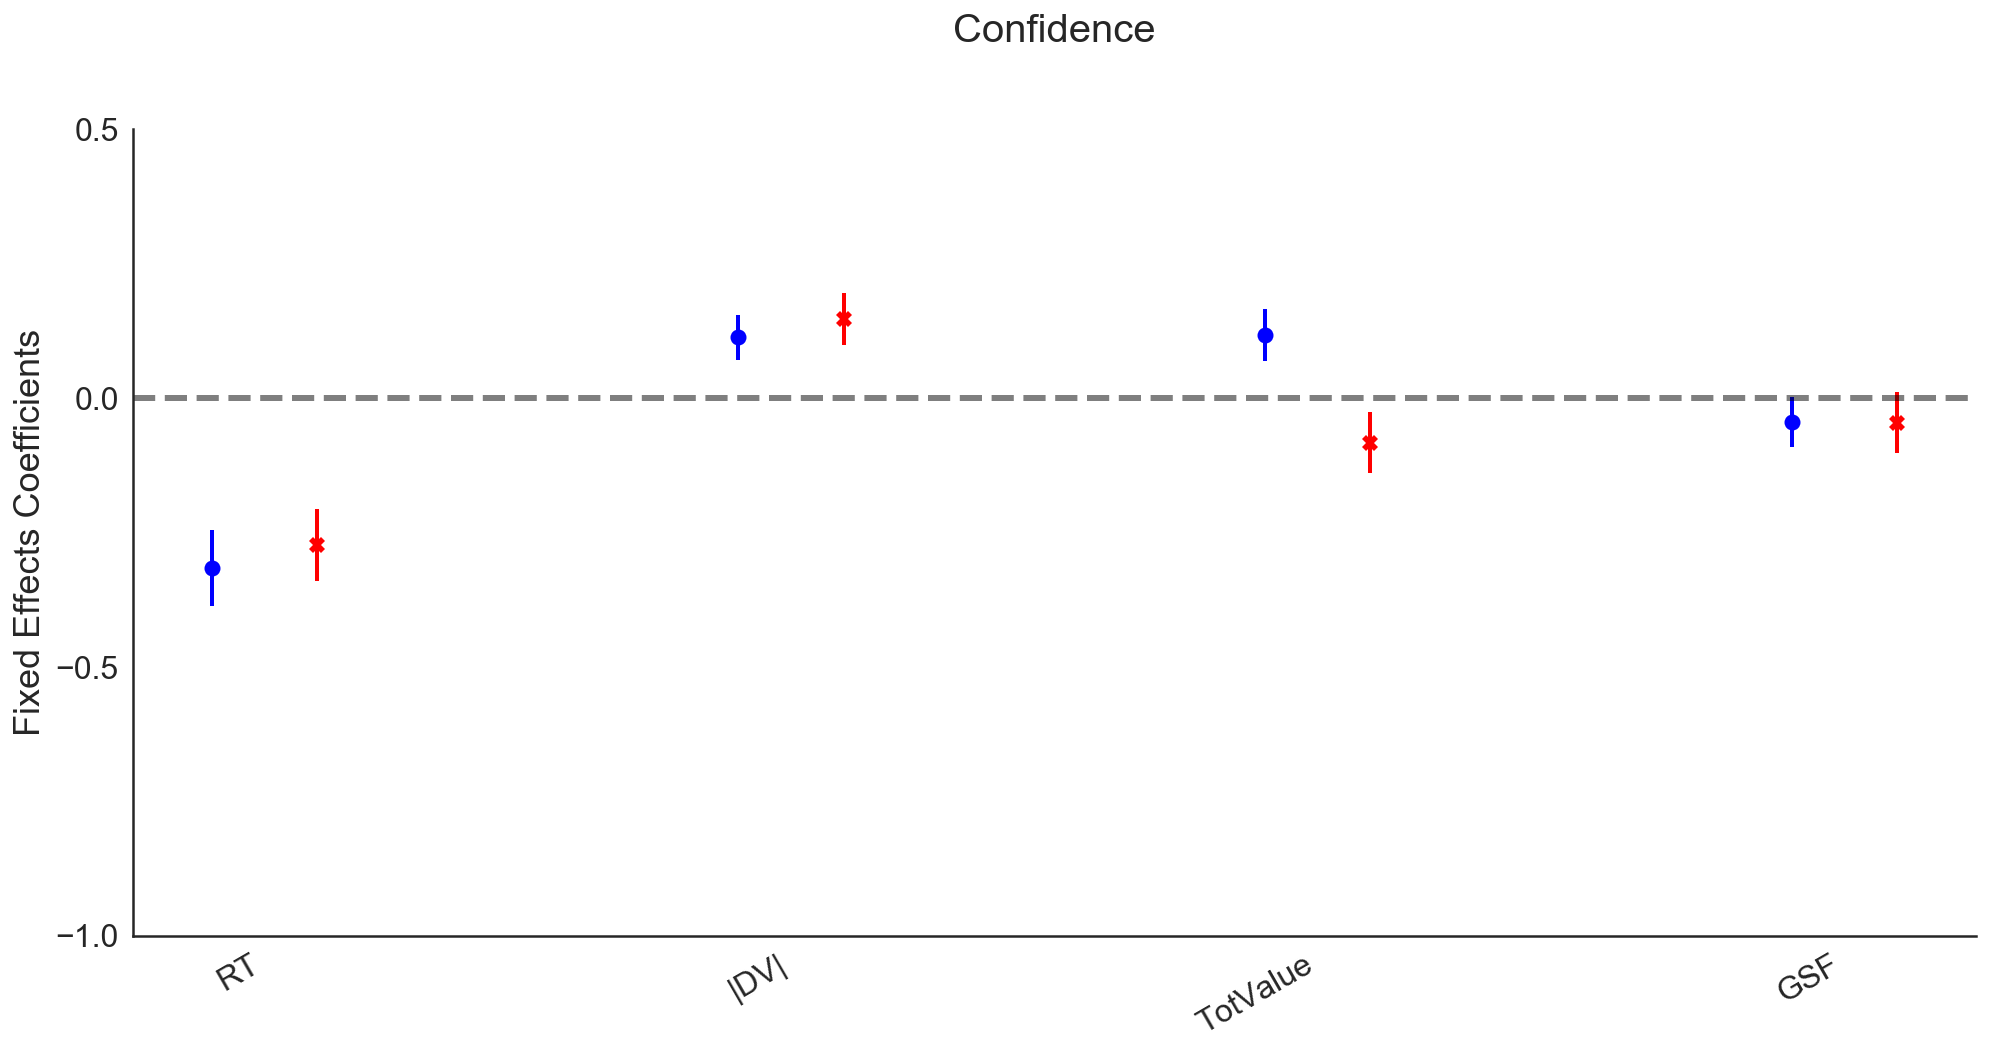

In [340]:
Coefpresplot2(conf_table_Like,conf_table_Dislike, title='Confidence', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0)

In [ ]:
# --------------END --------------------------------------------------

In [127]:
%%R

tmp <- as.data.frame(confint(glht(confidence_hmodel, mcp(status = "Tukey")))$confint)
tmp$Comparison <- rownames(tmp)
ggplot(tmp, aes(x = Comparison, y = Estimate, ymin = lwr, ymax = upr)) +
  geom_errorbar() + geom_point()


Error in mcp2matrix(model, linfct = linfct) : 
  Variable(s) ‘status’ have been specified in ‘linfct’ but cannot be found in ‘model’!


In [123]:
%%R
partCoefs[1]

$Part
    (Intercept)          zRT     zAbsDV     ZtotVal         zGSF
1   0.053956172 -0.546570673 0.09354633 -0.06483186 -0.073000122
2  -0.032432410 -0.408826186 0.14544563  0.15553500 -0.114879783
3   0.029160974 -0.301015615 0.18176701  0.13835929 -0.057523587
4  -0.070989277 -0.532048086 0.17898268  0.18524693 -0.107533512
5  -0.162327052 -0.503944921 0.14327398  0.31135652 -0.057214342
8   0.110761269  0.005772054 0.17164974  0.11385108 -0.003659855
9   0.015378102 -0.337277857 0.08170286  0.06278697 -0.062490017
10  0.088399300 -0.284355127 0.08516776 -0.01752362 -0.091684346
11  0.038496580 -0.267368404 0.12066686  0.09626380 -0.104387041
12  0.172003584 -0.127792415 0.20133129  0.00238783 -0.079765403
13  0.040086539 -0.138334740 0.08001637  0.11357048  0.038150625
14  0.162712624 -0.332809797 0.13330993 -0.11717894 -0.057176528
15  0.135841594  0.037681664 0.01688440 -0.02788867  0.008716010
16  0.256983044 -0.172397981 0.15696673 -0.17613695 -0.095238560
18  0.187502849 -0.

In [ ]:
%%R
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameLike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameLike)[j-1] <- a[j]
}
CoefsDataFrameLike

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = 4)
for (i in unique(data_exp1_DisLike[,"Part"])){
data_rgrs_subj  <- data_exp1_DisLike[ which(data_exp1_DisLike$Part==i), ]
rsults <- glm(zConf ~ zAbsDV + zRT  + ZtotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:5])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameDislike <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameDislike)[j-1] <- a[j]
}
CoefsDataFrameDislike

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameDislike),aes(x=variable, y=value), shape = 17, color='red', position = jitter) +
      geom_point(data = melt(CoefsDataFrameLike), aes(x=variable, y=value),color='blue', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Confidence ~ BehavParams + GSF") + theme(legend.position="Top") 
      
ggsave("Output/Confidence_Reg_Participant.tiff", units="in", width=5, height=4, dpi=300, compression = 'lzw')

plot2